# McHacks 26 - Bot or Not

### Imports

In [1]:
import numpy as np
import matplotlib as plt
from pathlib import Path
import json
import pandas as pd
import re
from transformers import AutoTokenizer
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
from pathlib import Path

# Toggle this in Colab when your datasets are stored on Google Drive.
USE_GOOGLE_DRIVE_DATA = True

# Adjust this only if your folder lives elsewhere in Drive.
GOOGLE_DRIVE_PROJECT_ROOT = Path("/content/drive/MyDrive/bot_or_not_McHacks_2026")
LOCAL_PROJECT_ROOT = Path(".")

IN_COLAB = "google.colab" in sys.modules
PROJECT_ROOT = LOCAL_PROJECT_ROOT

if IN_COLAB and USE_GOOGLE_DRIVE_DATA:
    from google.colab import drive
    !pip install emoji==0.6.0
    !pip install catboost
    !pip install transformers huggingface_hub datasets

    drive.mount("/content/drive", force_remount=False)
    PROJECT_ROOT = GOOGLE_DRIVE_PROJECT_ROOT
elif IN_COLAB:
    PROJECT_ROOT = LOCAL_PROJECT_ROOT

DATA_DIR = (PROJECT_ROOT / "data").resolve()
EXTERNAL_DATA_DIR = (PROJECT_ROOT / "external_data").resolve()

print(f"IN_COLAB={IN_COLAB}")
print(f"USE_GOOGLE_DRIVE_DATA={USE_GOOGLE_DRIVE_DATA}")
print(f"PROJECT_ROOT={PROJECT_ROOT}")
print(f"DATA_DIR={DATA_DIR}")
print(f"EXTERNAL_DATA_DIR={EXTERNAL_DATA_DIR}")



IN_COLAB=False
USE_GOOGLE_DRIVE_DATA=True
PROJECT_ROOT=.
DATA_DIR=/Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/data
EXTERNAL_DATA_DIR=/Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/external_data


### Data processing

In [3]:
if "DATA_DIR" not in globals():
    DATA_DIR = Path("data").resolve()
if "EXTERNAL_DATA_DIR" not in globals():
    EXTERNAL_DATA_DIR = Path("external_data").resolve()

print(f"Using DATA_DIR: {DATA_DIR}")
print(f"Using EXTERNAL_DATA_DIR: {EXTERNAL_DATA_DIR}")


def get_version(path):
    try:
        return int(path.stem.split(".")[-1])
    except ValueError:
        return None


posts_users_files = sorted(DATA_DIR.glob("dataset.posts&users.*.json"), key=get_version)
if not posts_users_files:
    raise FileNotFoundError(f"No dataset.posts&users.*.json files found in {DATA_DIR}")


combined = {}
bots_by_lang = {}


for path in posts_users_files:
    with path.open() as f:
        data = json.load(f)
    lang = data.get("lang")

    combined.setdefault(lang, {"posts": [], "users": [], "sources": []})
    combined[lang]["posts"].extend(data.get("posts", []))
    combined[lang]["users"].extend(data.get("users", []))
    combined[lang]["sources"].append(path.name)

    version = get_version(path)
    if version is not None:
        bots_path = DATA_DIR / f"dataset.bots.{version}.txt"
        if bots_path.exists():
            bots_by_lang.setdefault(lang, set()).update(bots_path.read_text().splitlines())


posts_en = pd.DataFrame(combined.get("en", {}).get("posts", []))
users_en = pd.DataFrame(combined.get("en", {}).get("users", []))
bot_ids_en = bots_by_lang.get("en", set())
if not users_en.empty:
    users_en["is_bot"] = users_en["id"].isin(bot_ids_en)

posts_fr = pd.DataFrame(combined.get("fr", {}).get("posts", []))
users_fr = pd.DataFrame(combined.get("fr", {}).get("users", []))
bot_ids_fr = bots_by_lang.get("fr", set())
if not users_fr.empty:
    users_fr["is_bot"] = users_fr["id"].isin(bot_ids_fr)

print("EN sources:", combined.get("en", {}).get("sources", []))
print(f"EN posts: {len(posts_en):,} users: {len(users_en):,} bot_ids: {len(bot_ids_en):,}")
print("FR sources:", combined.get("fr", {}).get("sources", []))
print(f"FR posts: {len(posts_fr):,} users: {len(users_fr):,} bot_ids: {len(bot_ids_fr):,}")


Using DATA_DIR: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/data
Using EXTERNAL_DATA_DIR: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/external_data
EN sources: ['dataset.posts&users.30.json', 'dataset.posts&users.32.json']
EN posts: 15,765 users: 546 bot_ids: 129
FR sources: ['dataset.posts&users.31.json', 'dataset.posts&users.33.json']
FR posts: 9,004 users: 343 bot_ids: 55


### Experiment parameters

In [4]:
EXPERIMENT_CONFIG = {
    "tokenizer_name": "cardiffnlp/twitter-xlm-roberta-base",

    "target_lang": "fr",
    "max_length": 96,
    "dedupe_users": True,
    "dedupe_posts": True,
    "scale_meta_features": True,

    "normalize_social_tokens": True,

    "strip_hashtag_symbol": True,

    "lowercase_text": True,
    "use_topic_features": False,
    "topic_match_mode": "word",  # options: "contains", "word"
    "topic_feature_scale": 0.5,
    "topic_include_cross_language_keywords": False,
    "topic_cross_langs": ["en"],
    "test_size": 0.20,
    "random_seed": 42,
    "validation_split": 0.15,
    "epochs": 10,
    "batch_size": 96,
    "learning_rate": 0.0008,
    "prediction_threshold": 0.62,
    "use_threshold_search": True,
    "threshold_search_min": 0.10,
    "threshold_search_max": 0.90,
    "threshold_search_steps": 161,
    "account_decision_rule": "mean",  # options: "mean", "any"
    "account_min_bot_posts": 1,
    "account_min_bot_post_rate": 0.0,
    "split_by_author": True,
    "ensemble_seeds": [13, 29, 42, 73, 101, 137, 173],
    "ensemble_aggregation": "median",  # options: "mean", "median"
    "use_external_pretrain": True,
    "external_pretrain_source": "airt_ml",
    "external_pretrain_download": True,
    "external_pretrain_hf_repo": "airt-ml/twitter-human-bots",
    "external_pretrain_hf_filename": "twitter_human_bots_dataset.csv",
    "external_pretrain_max_users": 20000,
    "external_pretrain_max_tweets_per_user": 5,
    "external_pretrain_max_posts": 120000,
    "external_pretrain_lang": "fr",
    "external_pretrain_sample_seed": 42,
    "external_pretrain_epochs": 1,
    "external_pretrain_batch_size": 128,
    "external_pretrain_use_balanced_weights": True,
    "use_second_stage_account_model": True,
    "use_logreg_account_model": True,
    "logreg_max_iter": 200,
    "logreg_min_posts": 2,
    "second_stage_profile": "regularized",  # options: "auto", "legacy", "regularized", "custom"
    "second_stage_use_blend": True,
    "second_stage_blend_alphas": [1.0, 0.90, 0.80, 0.70, 0.55, 0.40, 0.25, 0.10],
    "second_stage_min_gain_vs_ensemble": 1,

    "second_stage_max_extra_fp_vs_ensemble": 1,
    "second_stage_post_calibrate": True,
    "second_stage_account_min_bot_posts_grid": [1, 2, 3],
    "second_stage_account_min_bot_post_rate_grid": [0.0, 0.15, 0.25],

    "second_stage_min_val_accounts_for_booster": 25,
    "second_stage_use_oof_features": True,
    "second_stage_oof_folds": 4,
    "second_stage_oof_epochs": 4,
    "second_stage_oof_batch_size": 128,
    "second_stage_oof_seeds": [13, 42],
    "second_stage_oof_use_external_pretrain": True,
    "second_stage_learning_rate": 0.05,
    "second_stage_max_iter": 300,
    "second_stage_max_depth": 4,
    "second_stage_l2": 0.2,
    "second_stage_min_data_in_leaf": 20,
    "second_stage_subsample": 0.8,
    "second_stage_rsm": 0.8,
    "second_stage_od_wait": 50,
    "second_stage_use_balanced_weights": True,
    "use_class_weights": True,
    "embedding_dim": 96,
    "gru_units": 48,
    "aux_dense_units": 32,
    "head_dense_units": 48,
    "dropout_text": 0.40,
    "dropout_aux": 0.30,
    "dropout_head": 0.40,
    "early_stopping_patience": 2,
    "reduce_lr_patience": 2,
    "reduce_lr_factor": 0.50,
    "reduce_lr_min_lr": 1e-5,
    "error_analysis_min_topic_posts": 20,
    "error_analysis_min_topic_accounts": 5,
}

print("Experiment config loaded:")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"- {key}: {value}")




Experiment config loaded:
- tokenizer_name: cardiffnlp/twitter-xlm-roberta-base
- target_lang: fr
- max_length: 96
- dedupe_users: True
- dedupe_posts: True
- scale_meta_features: True
- normalize_social_tokens: True
- strip_hashtag_symbol: True
- lowercase_text: True
- use_topic_features: False
- topic_match_mode: word
- topic_feature_scale: 0.5
- topic_include_cross_language_keywords: False
- topic_cross_langs: ['en']
- test_size: 0.2
- random_seed: 42
- validation_split: 0.15
- epochs: 10
- batch_size: 96
- learning_rate: 0.0008
- prediction_threshold: 0.62
- use_threshold_search: True
- threshold_search_min: 0.1
- threshold_search_max: 0.9
- threshold_search_steps: 161
- account_decision_rule: mean
- account_min_bot_posts: 1
- account_min_bot_post_rate: 0.0
- split_by_author: True
- ensemble_seeds: [13, 29, 42, 73, 101, 137, 173]
- ensemble_aggregation: median
- use_external_pretrain: True
- external_pretrain_source: airt_ml
- external_pretrain_download: True
- external_pretrain_hf

### Tokenizing the text

In [5]:
import re

try:
    from transformers import AutoTokenizer
except ImportError as exc:
    raise ImportError("Install transformers first: pip install transformers") from exc

from sklearn.preprocessing import StandardScaler

if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")

TOKENIZER_NAME = str(EXPERIMENT_CONFIG["tokenizer_name"])
TARGET_LANG = str(EXPERIMENT_CONFIG.get("target_lang", "fr")).strip().lower()
MAX_LENGTH = int(EXPERIMENT_CONFIG["max_length"])
DEDUPE_USERS = bool(EXPERIMENT_CONFIG["dedupe_users"])
DEDUPE_POSTS = bool(EXPERIMENT_CONFIG["dedupe_posts"])
SCALE_META_FEATURES = bool(EXPERIMENT_CONFIG["scale_meta_features"])
NORMALIZE_SOCIAL_TOKENS = bool(EXPERIMENT_CONFIG.get("normalize_social_tokens", True))
STRIP_HASHTAG_SYMBOL = bool(EXPERIMENT_CONFIG.get("strip_hashtag_symbol", True))
LOWERCASE_TEXT = bool(EXPERIMENT_CONFIG.get("lowercase_text", False))

if TARGET_LANG not in {"en", "fr"}:
    raise ValueError('target_lang must be "en" or "fr".')


def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.replace("\n", " ").strip()

    if NORMALIZE_SOCIAL_TOKENS:
        text = re.sub(r"https?://\S+|www\.\S+", " <URL> ", text)
        text = re.sub(r"@\w+", " <USER> ", text)

    if STRIP_HASHTAG_SYMBOL:
        text = re.sub(r"#(\w+)", r" \1 ", text)

    if LOWERCASE_TEXT:
        text = text.lower()

    text = re.sub(r"\s+", " ", text)
    return text


def add_text_features(df):
    out = df.copy()

    raw_text = out["text"].fillna("").map(lambda x: x if isinstance(x, str) else "")
    out["text_clean"] = raw_text.map(clean_text)

    # Counts from raw text retain signal even when text_clean is normalized.
    out["url_count"] = raw_text.str.count(r"https?://\S+|www\.\S+")
    out["mention_count"] = raw_text.str.count(r"@\w+")
    out["hashtag_count"] = raw_text.str.count(r"#\w+")

    out["char_count"] = out["text_clean"].str.len()
    out["word_count"] = out["text_clean"].str.split().str.len()
    out["exclamation_count"] = out["text_clean"].str.count(r"!")
    out["question_count"] = out["text_clean"].str.count(r"\?")
    return out


posts_by_lang = {"en": posts_en, "fr": posts_fr}
users_by_lang = {"en": users_en, "fr": users_fr}

posts_lang = posts_by_lang.get(TARGET_LANG, pd.DataFrame())
users_lang = users_by_lang.get(TARGET_LANG, pd.DataFrame())

if posts_lang.empty or users_lang.empty:
    raise ValueError(
        f"Run the data processing cell first to load {TARGET_LANG.upper()} data. "
        f"Posts={len(posts_lang)}, users={len(users_lang)}"
    )

users_lang_labeled = (
    users_lang.drop_duplicates(subset="id", keep="last").copy()
    if DEDUPE_USERS
    else users_lang.copy()
)
posts_lang_unique = (
    posts_lang.drop_duplicates(subset="id", keep="last").copy()
    if DEDUPE_POSTS
    else posts_lang.copy()
)

# Keep downstream cell compatibility by reusing existing variable names.
users_en = users_lang.copy()
posts_en = posts_lang.copy()
users_en_labeled = users_lang_labeled.copy()

label_map_lang = users_lang_labeled.set_index("id")["is_bot"]
train_en = posts_lang_unique.copy()
train_en["is_bot"] = train_en["author_id"].map(label_map_lang)
train_en = train_en.dropna(subset=["is_bot"]).copy()
train_en["is_bot"] = train_en["is_bot"].astype("int64")

train_en = add_text_features(train_en)

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
encodings_en = tokenizer(
    train_en["text_clean"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
)

feature_cols_en = [
    "char_count",
    "word_count",
    "url_count",
    "mention_count",
    "hashtag_count",
    "exclamation_count",
    "question_count",
]
X_meta_en = train_en[feature_cols_en].to_numpy(dtype=np.float32)
y_en = train_en["is_bot"].to_numpy(dtype=np.int64)

if SCALE_META_FEATURES:
    scaler_en = StandardScaler()
    X_meta_en_scaled = scaler_en.fit_transform(X_meta_en).astype(np.float32)
else:
    scaler_en = None
    X_meta_en_scaled = X_meta_en.copy()

print(f"Target language: {TARGET_LANG.upper()}")
print(f"Tokenizer: {TOKENIZER_NAME}")
print(f"Labeled posts used: {len(train_en):,}")
print(f"Token tensor shape: {np.asarray(encodings_en['input_ids']).shape}")
print(f"Meta feature shape: {X_meta_en_scaled.shape}, label shape: {y_en.shape}")
print(f"Dedupe users/posts: {DEDUPE_USERS}/{DEDUPE_POSTS}")
print(f"Scale metadata features: {SCALE_META_FEATURES}")
print(f"Normalize URLs/users: {NORMALIZE_SOCIAL_TOKENS}")
print(f"Strip hashtag symbol: {STRIP_HASHTAG_SYMBOL}")
print(f"Lowercase text: {LOWERCASE_TEXT}")


Target language: FR
Tokenizer: cardiffnlp/twitter-xlm-roberta-base
Labeled posts used: 9,004
Token tensor shape: (9004, 96)
Meta feature shape: (9004, 7), label shape: (9004,)
Dedupe users/posts: True/True
Scale metadata features: True
Normalize URLs/users: True
Strip hashtag symbol: True
Lowercase text: True


## External data pretraining

In [6]:
from pathlib import Path
import json
import random

import numpy as np
import pandas as pd

if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")
if "tokenizer" not in globals() or "add_text_features" not in globals():
    raise ValueError("Run the Tokenizing the text cell first.")

USE_EXTERNAL_PRETRAIN = bool(EXPERIMENT_CONFIG.get("use_external_pretrain", False))
if not USE_EXTERNAL_PRETRAIN:
    print("External pretraining disabled. Set use_external_pretrain=True to enable.")
else:
    external_source = str(EXPERIMENT_CONFIG.get("external_pretrain_source", "fox8")).lower()
    max_users = int(EXPERIMENT_CONFIG.get("external_pretrain_max_users", 20000))
    max_posts = int(EXPERIMENT_CONFIG.get("external_pretrain_max_posts", 120000))
    max_tweets_per_user = int(EXPERIMENT_CONFIG.get("external_pretrain_max_tweets_per_user", 5))
    lang_filter = str(EXPERIMENT_CONFIG.get("external_pretrain_lang", EXPERIMENT_CONFIG.get("target_lang", "fr"))).lower().strip()
    sample_seed = int(EXPERIMENT_CONFIG.get("external_pretrain_sample_seed", 42))

    random.seed(sample_seed)

    data_dir = Path(globals().get("EXTERNAL_DATA_DIR", Path("external_data")))
    external_pretrain_rows = []

    if external_source in {"fox8"}:
        fox8_path = data_dir / "fox8_23_dataset.ndjson"
        if not fox8_path.exists():
            raise FileNotFoundError(f"Missing {fox8_path}")
        # Reservoir sample users to avoid loading the full file.
        sampled_users = []
        with fox8_path.open() as f:
            for i, line in enumerate(f):
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    continue
                if len(sampled_users) < max_users:
                    sampled_users.append(obj)
                else:
                    j = random.randint(0, i)
                    if j < max_users:
                        sampled_users[j] = obj

        for user in sampled_users:
            label = str(user.get("label", "")).strip().lower()
            if not label:
                continue
            if label in {"human", "normal"}:
                is_bot = 0
            elif label in {"bot", "spambot", "fake", "automated"}:
                is_bot = 1
            else:
                # Unknown label; skip
                continue

            user_id = user.get("user_id")
            tweets = user.get("user_tweets", []) or []

            per_user_count = 0
            for tweet in tweets:
                if len(external_pretrain_rows) >= max_posts or per_user_count >= max_tweets_per_user:
                    break
                text = tweet.get("text") if isinstance(tweet, dict) else None
                if not text:
                    continue
                if lang_filter:
                    tweet_lang = str(tweet.get("lang", "")).lower().strip() if isinstance(tweet, dict) else ""
                    if tweet_lang and tweet_lang != lang_filter:
                        continue
                external_pretrain_rows.append({"author_id": f"fox8_{user_id}", "text": text, "is_bot": is_bot})
                per_user_count += 1

    elif external_source in {"airt_ml", "airt-ml", "twitter_human_bots", "twitter-human-bots", "hf_twitter_human_bots"}:
        hf_repo = str(EXPERIMENT_CONFIG.get("external_pretrain_hf_repo", "airt-ml/twitter-human-bots"))
        hf_filename = str(EXPERIMENT_CONFIG.get("external_pretrain_hf_filename", "twitter_human_bots_dataset.csv"))
        download_hf = bool(EXPERIMENT_CONFIG.get("external_pretrain_download", True))
        local_path = data_dir / hf_filename
        hf_path = f"hf://datasets/{hf_repo}/{hf_filename}"

        if download_hf and not local_path.exists():
            try:
                from huggingface_hub import hf_hub_download
                hf_hub_download(
                    repo_id=hf_repo,
                    filename=hf_filename,
                    repo_type="dataset",
                    local_dir=str(data_dir),
                    local_dir_use_symlinks=False,
                )
                print(f"Downloaded {hf_filename} to {local_path}")
            except Exception as exc:
                print(f"HF download failed ({exc}). Will try direct read.")

        try:
            if local_path.exists():
                external_df = pd.read_csv(local_path)
            else:
                external_df = pd.read_csv(hf_path)
        except Exception as exc:
            raise FileNotFoundError(
                f"Could not load {hf_path} or {local_path}. Download manually if needed. Error: {exc}"
            )

        # Drop index-like columns if present
        if "Unnamed: 0" in external_df.columns:
            external_df = external_df.drop(columns=["Unnamed: 0"])

        def _find_col(columns, candidates, contains=None):
            for c in candidates:
                if c in columns:
                    return c
            if contains:
                for c in columns:
                    if contains in c.lower():
                        return c
            return None

        # Language column
        lang_col = _find_col(external_df.columns, ["lang", "language", "tweet_lang", "tweet_language"], contains="lang")
        if lang_col and lang_filter:
            external_df = external_df[external_df[lang_col].astype(str).str.lower().str.strip() == lang_filter]

        # Text column (this dataset is user-level; use description if no tweet text)
        text_col = _find_col(external_df.columns, ["description", "text", "tweet", "content", "full_text"], contains="text")
        if text_col is None:
            text_col = _find_col(external_df.columns, ["tweet_text", "tweet_content"], contains="tweet")
        if text_col is None:
            raise ValueError("No text/description column found in twitter_human_bots_dataset.csv")

        # Label column
        label_col = _find_col(external_df.columns, ["account_type", "label", "is_bot", "bot", "bot_label", "account_type", "type"], contains="bot")
        if label_col is None:
            raise ValueError("No label column found in twitter_human_bots_dataset.csv")

        # User id column (optional)
        user_col = _find_col(external_df.columns, ["id", "user_id", "userid", "author_id", "user", "screen_name", "username"], contains="user")
        if user_col is None:
            external_df["_author_id"] = np.arange(len(external_df)).astype(str)
            user_col = "_author_id"

        def _label_to_bot(value):
            if pd.isna(value):
                return None
            if isinstance(value, (int, np.integer)):
                return int(value)
            if isinstance(value, (float, np.floating)):
                return int(value >= 0.5)
            v = str(value).strip().lower()
            if v in {"bot", "spambot", "fake", "automated", "1", "true", "yes", "bot_account"}:
                return 1
            if v in {"human", "normal", "real", "0", "false", "no", "human_account"}:
                return 0
            return None

        sampled = external_df.sample(n=min(len(external_df), max_posts), random_state=sample_seed)
        user_counts = {}
        for _, row in sampled.iterrows():
            if len(external_pretrain_rows) >= max_posts:
                break
            uid = str(row[user_col])
            if user_counts.get(uid, 0) >= max_tweets_per_user:
                continue
            label = _label_to_bot(row[label_col])
            if label is None:
                continue
            text = row[text_col]
            if not isinstance(text, str) or not text.strip():
                continue
            external_pretrain_rows.append({"author_id": f"airt_{uid}", "text": text, "is_bot": label})
            user_counts[uid] = user_counts.get(uid, 0) + 1

    else:
        raise ValueError("Unsupported external_pretrain_source. Use fox8 or airt_ml.")

    external_pretrain_df = pd.DataFrame(external_pretrain_rows)
    if external_pretrain_df.empty:
        raise ValueError("No external pretrain rows built. Check labels/lang filter.")

    external_pretrain_df = external_pretrain_df.dropna(subset=["text"]).reset_index(drop=True)
    external_pretrain_df = add_text_features(external_pretrain_df)

    external_pretrain_encodings = tokenizer(
        external_pretrain_df["text_clean"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_attention_mask=True,
    )

    external_pretrain_input_ids = np.asarray(external_pretrain_encodings["input_ids"], dtype=np.int32)
    external_pretrain_attention_mask = np.asarray(external_pretrain_encodings["attention_mask"], dtype=np.float32)

    external_pretrain_meta = external_pretrain_df[feature_cols_en].to_numpy(dtype=np.float32)
    if "scaler_en" in globals() and SCALE_META_FEATURES:
        external_pretrain_meta_scaled = scaler_en.transform(external_pretrain_meta).astype(np.float32)
    else:
        external_pretrain_meta_scaled = external_pretrain_meta

    external_pretrain_labels = external_pretrain_df["is_bot"].to_numpy(dtype=np.int64)

    print("External pretrain dataset prepared:")
    print(f"- source: {external_source}")
    print(f"- rows: {len(external_pretrain_df):,}")
    print(
        f"- bots: {int((external_pretrain_labels==1).sum())}, humans: {int((external_pretrain_labels==0).sum())}"
    )
    print(f"- max_length: {MAX_LENGTH}")


External pretrain dataset prepared:
- source: airt_ml
- rows: 375
- bots: 104, humans: 271
- max_length: 96


## Train-Test split for model

In [7]:
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

try:
    import tensorflow as tf
except ImportError as exc:
    raise ImportError("Install tensorflow first: pip install tensorflow") from exc

if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")

TEST_SIZE = float(EXPERIMENT_CONFIG["test_size"])
RANDOM_SEED = int(EXPERIMENT_CONFIG["random_seed"])
VALIDATION_SPLIT = float(EXPERIMENT_CONFIG["validation_split"])
EPOCHS = int(EXPERIMENT_CONFIG["epochs"])
BATCH_SIZE = int(EXPERIMENT_CONFIG["batch_size"])
LEARNING_RATE = float(EXPERIMENT_CONFIG["learning_rate"])
PREDICTION_THRESHOLD = float(EXPERIMENT_CONFIG["prediction_threshold"])
USE_CLASS_WEIGHTS = bool(EXPERIMENT_CONFIG["use_class_weights"])
USE_TOPIC_FEATURES = bool(EXPERIMENT_CONFIG["use_topic_features"])
TOPIC_MATCH_MODE = str(EXPERIMENT_CONFIG["topic_match_mode"])
TOPIC_FEATURE_SCALE = float(EXPERIMENT_CONFIG.get("topic_feature_scale", 1.0))
TOPIC_INCLUDE_CROSS_LANG_KEYWORDS = bool(EXPERIMENT_CONFIG.get("topic_include_cross_language_keywords", False))
TOPIC_CROSS_LANGS = EXPERIMENT_CONFIG.get("topic_cross_langs", [])

TARGET_LANG = str(EXPERIMENT_CONFIG.get("target_lang", "fr")).strip().lower()
SPLIT_BY_AUTHOR = bool(EXPERIMENT_CONFIG.get("split_by_author", True))

USE_THRESHOLD_SEARCH = bool(EXPERIMENT_CONFIG.get("use_threshold_search", False))
THRESHOLD_SEARCH_MIN = float(EXPERIMENT_CONFIG.get("threshold_search_min", 0.10))
THRESHOLD_SEARCH_MAX = float(EXPERIMENT_CONFIG.get("threshold_search_max", 0.90))
THRESHOLD_SEARCH_STEPS = int(EXPERIMENT_CONFIG.get("threshold_search_steps", 81))
ACCOUNT_DECISION_RULE = str(EXPERIMENT_CONFIG.get("account_decision_rule", "mean"))
ACCOUNT_MIN_BOT_POSTS = int(EXPERIMENT_CONFIG.get("account_min_bot_posts", 1))
ACCOUNT_MIN_BOT_POST_RATE = float(EXPERIMENT_CONFIG.get("account_min_bot_post_rate", 0.0))

EMBEDDING_DIM = int(EXPERIMENT_CONFIG["embedding_dim"])
GRU_UNITS = int(EXPERIMENT_CONFIG["gru_units"])
AUX_DENSE_UNITS = int(EXPERIMENT_CONFIG["aux_dense_units"])
HEAD_DENSE_UNITS = int(EXPERIMENT_CONFIG["head_dense_units"])
DROPOUT_TEXT = float(EXPERIMENT_CONFIG["dropout_text"])
DROPOUT_AUX = float(EXPERIMENT_CONFIG["dropout_aux"])
DROPOUT_HEAD = float(EXPERIMENT_CONFIG["dropout_head"])

EARLY_STOPPING_PATIENCE = int(EXPERIMENT_CONFIG["early_stopping_patience"])
REDUCE_LR_PATIENCE = int(EXPERIMENT_CONFIG["reduce_lr_patience"])
REDUCE_LR_FACTOR = float(EXPERIMENT_CONFIG["reduce_lr_factor"])
REDUCE_LR_MIN_LR = float(EXPERIMENT_CONFIG["reduce_lr_min_lr"])

if not (0.0 < TEST_SIZE < 1.0):
    raise ValueError("test_size must be between 0 and 1.")
if not (0.0 <= VALIDATION_SPLIT < 1.0):
    raise ValueError("validation_split must be in [0, 1).")
if TOPIC_MATCH_MODE not in {"contains", "word"}:
    raise ValueError('topic_match_mode must be "contains" or "word".')
if ACCOUNT_DECISION_RULE not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')
if ACCOUNT_MIN_BOT_POSTS < 1:
    raise ValueError("account_min_bot_posts must be >= 1.")
if not (0.0 <= ACCOUNT_MIN_BOT_POST_RATE <= 1.0):
    raise ValueError("account_min_bot_post_rate must be in [0, 1].")
if USE_THRESHOLD_SEARCH:
    if not (0.0 < THRESHOLD_SEARCH_MIN < 1.0 and 0.0 < THRESHOLD_SEARCH_MAX < 1.0):
        raise ValueError("threshold_search_min and threshold_search_max must be in (0, 1).")
    if THRESHOLD_SEARCH_MIN >= THRESHOLD_SEARCH_MAX:
        raise ValueError("threshold_search_min must be smaller than threshold_search_max.")
    if THRESHOLD_SEARCH_STEPS < 2:
        raise ValueError("threshold_search_steps must be >= 2.")


def load_target_topic_keywords():
    topic_keywords = {}
    target_langs = [TARGET_LANG]
    if TARGET_LANG == "fr" and TOPIC_INCLUDE_CROSS_LANG_KEYWORDS:
        for lang in TOPIC_CROSS_LANGS:
            if isinstance(lang, str) and lang.strip().lower() not in target_langs:
                target_langs.append(lang.strip().lower())
    for lang in target_langs:
        for source_name in combined.get(lang, {}).get("sources", []):
            source_path = DATA_DIR / source_name
            with source_path.open() as f:
                payload = json.load(f)
            for topic_item in payload.get("metadata", {}).get("topics", []):
                topic = str(topic_item.get("topic", "")).strip().lower()
                if not topic:
                    continue
                keywords = {
                    str(keyword).strip().lower()
                    for keyword in topic_item.get("keywords", [])
                    if str(keyword).strip()
                }
                keywords.add(topic)
                topic_keywords.setdefault(topic, set()).update(keywords)
    return {topic: sorted(values, key=len, reverse=True) for topic, values in topic_keywords.items()}
def add_topic_features(df, topic_keywords, match_mode):
    out = df.copy()
    text_lower = out["text_clean"].str.lower()
    topic_cols = []
    for topic, keywords in topic_keywords.items():
        col = f"topic_{topic}"
        topic_cols.append(col)
        if not keywords:
            out[col] = 0
            continue
        if match_mode == "word":
            pattern = "|".join(rf"\\b{re.escape(keyword)}\\b" for keyword in keywords)
        else:
            pattern = "|".join(re.escape(keyword) for keyword in keywords)
        out[col] = text_lower.str.contains(pattern, regex=True).astype(np.int8)
    return out, topic_cols


def compute_account_score(author_ids, true_labels, pred_probs, threshold, decision_rule):
    cfg = globals().get("EXPERIMENT_CONFIG", {})
    min_bot_posts = int(cfg.get("account_min_bot_posts", globals().get("ACCOUNT_MIN_BOT_POSTS", 1)))
    min_bot_post_rate = float(cfg.get("account_min_bot_post_rate", globals().get("ACCOUNT_MIN_BOT_POST_RATE", 0.0)))

    tmp = pd.DataFrame(
        {
            "author_id": author_ids,
            "true_is_bot": np.asarray(true_labels, dtype=np.int64),
            "pred_prob": np.asarray(pred_probs, dtype=np.float32),
        }
    )
    tmp["pred_post"] = (tmp["pred_prob"] >= threshold).astype(np.int64)

    account = (
        tmp.groupby("author_id", as_index=False)
        .agg(
            true_is_bot=("true_is_bot", "max"),
            mean_prob=("pred_prob", "mean"),
            any_pred=("pred_post", "max"),
            bot_post_count=("pred_post", "sum"),
            n_posts=("pred_post", "size"),
        )
    )

    if decision_rule == "any":
        pred = account["any_pred"].to_numpy(dtype=np.int64)
    else:
        pred = (account["mean_prob"].to_numpy(dtype=np.float32) >= float(threshold)).astype(np.int64)

    if min_bot_posts > 1:
        pred = pred & (account["bot_post_count"].to_numpy(dtype=np.int64) >= int(min_bot_posts))
    if min_bot_post_rate > 0.0:
        n_posts = np.maximum(account["n_posts"].to_numpy(dtype=np.float32), 1.0)
        rates = account["bot_post_count"].to_numpy(dtype=np.float32) / n_posts
        pred = pred & (rates >= float(min_bot_post_rate))

    account["pred_is_bot"] = pred.astype(np.int64)

    tp_accounts = int(((account["true_is_bot"] == 1) & (account["pred_is_bot"] == 1)).sum())
    fn_accounts = int(((account["true_is_bot"] == 1) & (account["pred_is_bot"] == 0)).sum())
    fp_accounts = int(((account["true_is_bot"] == 0) & (account["pred_is_bot"] == 1)).sum())

    score = (4 * tp_accounts) - (1 * fn_accounts) - (2 * fp_accounts)
    return score, tp_accounts, fn_accounts, fp_accounts, len(account)


def predict_for_indices(model, post_indices):
    if len(post_indices) == 0:
        return np.array([], dtype=np.float32)
    return model.predict(
        {
            "input_ids": input_ids_en[post_indices],
            "attention_mask": attention_mask_en[post_indices],
            "aux_features": X_aux_en[post_indices],
        },
        verbose=0,
    ).ravel()


if USE_TOPIC_FEATURES:
    topic_keywords_en = load_target_topic_keywords()
    train_en_model, topic_feature_cols_en = add_topic_features(train_en, topic_keywords_en, TOPIC_MATCH_MODE)
else:
    train_en_model = train_en.copy()
    topic_feature_cols_en = []

input_ids_en = np.asarray(encodings_en["input_ids"], dtype=np.int32)
attention_mask_en = np.asarray(encodings_en["attention_mask"], dtype=np.float32)
X_topic_en = (
    train_en_model[topic_feature_cols_en].to_numpy(dtype=np.float32)
    if topic_feature_cols_en
    else np.zeros((len(train_en_model), 0), dtype=np.float32)
)
if TOPIC_FEATURE_SCALE != 1.0:
    X_topic_en = X_topic_en * TOPIC_FEATURE_SCALE
X_aux_en = np.concatenate([X_meta_en_scaled, X_topic_en], axis=1)

all_post_idx = np.arange(len(y_en))

if SPLIT_BY_AUTHOR:
    author_labels_df = (
        train_en_model.groupby("author_id", as_index=False)["is_bot"]
        .max()
        .rename(columns={"is_bot": "account_is_bot"})
    )
    all_authors = author_labels_df["author_id"].to_numpy()
    all_author_labels = author_labels_df["account_is_bot"].to_numpy(dtype=np.int64)

    train_authors, test_authors = train_test_split(
        all_authors,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        stratify=all_author_labels,
    )

    if VALIDATION_SPLIT > 0:
        train_author_labels = (
            author_labels_df.set_index("author_id").loc[train_authors, "account_is_bot"].to_numpy(dtype=np.int64)
        )
        fit_authors, val_authors = train_test_split(
            train_authors,
            test_size=VALIDATION_SPLIT,
            random_state=RANDOM_SEED,
            stratify=train_author_labels,
        )
    else:
        fit_authors = train_authors
        val_authors = np.array([], dtype=all_authors.dtype)

    fit_author_set = set(fit_authors.tolist())
    val_author_set = set(val_authors.tolist())
    test_author_set = set(test_authors.tolist())

    fit_idx = np.flatnonzero(train_en_model["author_id"].isin(fit_author_set).to_numpy())
    val_idx = np.flatnonzero(train_en_model["author_id"].isin(val_author_set).to_numpy())
    test_idx = np.flatnonzero(train_en_model["author_id"].isin(test_author_set).to_numpy())
    split_mode = "author"
else:
    train_idx, test_idx = train_test_split(
        all_post_idx,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        stratify=y_en,
    )

    if VALIDATION_SPLIT > 0:
        fit_idx, val_idx = train_test_split(
            train_idx,
            test_size=VALIDATION_SPLIT,
            random_state=RANDOM_SEED,
            stratify=y_en[train_idx],
        )
    else:
        fit_idx = train_idx
        val_idx = np.array([], dtype=np.int64)

    split_mode = "post"

X_fit_ids, X_test_ids = input_ids_en[fit_idx], input_ids_en[test_idx]
X_fit_mask, X_test_mask = attention_mask_en[fit_idx], attention_mask_en[test_idx]
X_fit_aux, X_test_aux = X_aux_en[fit_idx], X_aux_en[test_idx]
y_fit, y_test = y_en[fit_idx], y_en[test_idx]

X_val_ids = input_ids_en[val_idx] if len(val_idx) else None
X_val_mask = attention_mask_en[val_idx] if len(val_idx) else None
X_val_aux = X_aux_en[val_idx] if len(val_idx) else None
y_val = y_en[val_idx] if len(val_idx) else None

fit_author_ids = np.unique(train_en_model.iloc[fit_idx]["author_id"].to_numpy())
val_author_ids = np.unique(train_en_model.iloc[val_idx]["author_id"].to_numpy()) if len(val_idx) else np.array([])
test_author_ids = np.unique(train_en_model.iloc[test_idx]["author_id"].to_numpy())

class_weight_dict = None
if USE_CLASS_WEIGHTS:
    classes = np.unique(y_fit)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_fit)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}


def build_multifeature_model(
    vocab_size,
    seq_len,
    aux_dim,
    embedding_dim,
    gru_units,
    aux_dense_units,
    head_dense_units,
    dropout_text,
    dropout_aux,
    dropout_head,
    learning_rate,
):
    ids_input = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="input_ids")
    mask_input = tf.keras.layers.Input(shape=(seq_len,), dtype="float32", name="attention_mask")
    aux_input = tf.keras.layers.Input(shape=(aux_dim,), dtype="float32", name="aux_features")

    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="token_embedding")(ids_input)
    mask = tf.keras.layers.Reshape((seq_len, 1))(mask_input)
    x = tf.keras.layers.Multiply()([x, mask])
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units))(x)
    x = tf.keras.layers.Dropout(dropout_text)(x)

    aux = tf.keras.layers.Dense(aux_dense_units, activation="relu")(aux_input)
    aux = tf.keras.layers.Dropout(dropout_aux)(aux)

    merged = tf.keras.layers.Concatenate()([x, aux])
    merged = tf.keras.layers.Dense(head_dense_units, activation="relu")(merged)
    merged = tf.keras.layers.Dropout(dropout_head)(merged)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(merged)

    model = tf.keras.Model(inputs=[ids_input, mask_input, aux_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")],
    )
    return model


model_en = build_multifeature_model(
    vocab_size=tokenizer.vocab_size,
    seq_len=MAX_LENGTH,
    aux_dim=X_fit_aux.shape[1],
    embedding_dim=EMBEDDING_DIM,
    gru_units=GRU_UNITS,
    aux_dense_units=AUX_DENSE_UNITS,
    head_dense_units=HEAD_DENSE_UNITS,
    dropout_text=DROPOUT_TEXT,
    dropout_aux=DROPOUT_AUX,
    dropout_head=DROPOUT_HEAD,
    learning_rate=LEARNING_RATE,
)

has_validation = len(val_idx) > 0
callbacks = []
if has_validation and EARLY_STOPPING_PATIENCE > 0:
    callbacks.append(
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
        )
    )
if has_validation and REDUCE_LR_PATIENCE > 0:
    callbacks.append(
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc",
            mode="max",
            factor=REDUCE_LR_FACTOR,
            patience=REDUCE_LR_PATIENCE,
            min_lr=REDUCE_LR_MIN_LR,
        )
    )

train_inputs = {
    "input_ids": X_fit_ids,
    "attention_mask": X_fit_mask,
    "aux_features": X_fit_aux,
}

fit_kwargs = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "class_weight": class_weight_dict,
    "callbacks": callbacks,
    "verbose": 1,
}
if has_validation:
    fit_kwargs["validation_data"] = (
        {
            "input_ids": X_val_ids,
            "attention_mask": X_val_mask,
            "aux_features": X_val_aux,
        },
        y_val,
    )

history_en = model_en.fit(train_inputs, y_fit, **fit_kwargs)

post_prob_fit = predict_for_indices(model_en, fit_idx)
post_prob_val = predict_for_indices(model_en, val_idx)
post_prob_test = predict_for_indices(model_en, test_idx)

y_prob = post_prob_test.copy()
threshold_search_results_en = pd.DataFrame()
SELECTED_THRESHOLD = PREDICTION_THRESHOLD
best_threshold_val_score = None

if has_validation and USE_THRESHOLD_SEARCH:
    val_author_ids_for_score = train_en_model.iloc[val_idx]["author_id"].to_numpy()
    search_rows = []
    for threshold in np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS):
        score, tp_acc, fn_acc, fp_acc, n_accounts = compute_account_score(
            author_ids=val_author_ids_for_score,
            true_labels=y_val,
            pred_probs=post_prob_val,
            threshold=float(threshold),
            decision_rule=ACCOUNT_DECISION_RULE,
        )
        search_rows.append(
            {
                "threshold": float(threshold),
                "score": int(score),
                "tp_accounts": int(tp_acc),
                "fn_accounts": int(fn_acc),
                "fp_accounts": int(fp_acc),
                "n_accounts": int(n_accounts),
            }
        )

    threshold_search_results_en = pd.DataFrame(search_rows)
    best_row = threshold_search_results_en.sort_values(
        by=["score", "fp_accounts", "tp_accounts", "threshold"],
        ascending=[False, True, False, False],
    ).iloc[0]

    SELECTED_THRESHOLD = float(best_row["threshold"])
    best_threshold_val_score = int(best_row["score"])

y_pred = (y_prob >= SELECTED_THRESHOLD).astype(np.int64)

test_author_ids_for_score = train_en_model.iloc[test_idx]["author_id"].to_numpy()
(
    test_score,
    test_tp_accounts,
    test_fn_accounts,
    test_fp_accounts,
    test_n_accounts,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_test,
    pred_probs=y_prob,
    threshold=SELECTED_THRESHOLD,
    decision_rule=ACCOUNT_DECISION_RULE,
)

(
    baseline_test_score,
    baseline_tp_accounts,
    baseline_fn_accounts,
    baseline_fp_accounts,
    baseline_n_accounts,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_test,
    pred_probs=y_prob,
    threshold=PREDICTION_THRESHOLD,
    decision_rule=ACCOUNT_DECISION_RULE,
)

print(f"Split mode: {split_mode}")
print(f"Topic features enabled: {USE_TOPIC_FEATURES}")
print(f"Topic match mode: {TOPIC_MATCH_MODE}")
print(f"Account decision rule: {ACCOUNT_DECISION_RULE}")
print(f"Account minimum bot posts: {ACCOUNT_MIN_BOT_POSTS}")
print(f"Account minimum bot-post rate: {ACCOUNT_MIN_BOT_POST_RATE:.2f}")
print("Topic columns:", topic_feature_cols_en)
print(f"Split sizes (fit/val/test posts): {len(fit_idx)}/{len(val_idx)}/{len(test_idx)}")
print(
    f"Split sizes (fit/val/test accounts): {len(fit_author_ids)}/{len(val_author_ids)}/{len(test_author_ids)}"
)
print(f"Default threshold from config: {PREDICTION_THRESHOLD:.4f}")
print(f"Selected threshold used on test: {SELECTED_THRESHOLD:.4f}")
if best_threshold_val_score is not None:
    print(f"Best validation score from threshold search: {best_threshold_val_score}")
print(f"Test Accuracy (post-level): {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC (post-level): {roc_auc_score(y_test, y_prob):.4f}")
print(
    f"Test account score @ selected threshold -> score={test_score}, TP={test_tp_accounts}, FN={test_fn_accounts}, FP={test_fp_accounts}, accounts={test_n_accounts}"
)
print(
    f"Test account score @ config threshold -> score={baseline_test_score}, TP={baseline_tp_accounts}, FN={baseline_fn_accounts}, FP={baseline_fp_accounts}, accounts={baseline_n_accounts}"
)
print(classification_report(y_test, y_pred, digits=4))



Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - accuracy: 0.6647 - auc: 0.6952 - loss: 0.6484 - val_accuracy: 0.7491 - val_auc: 0.8201 - val_loss: 0.5326 - learning_rate: 8.0000e-04
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.8734 - auc: 0.9163 - loss: 0.3586 - val_accuracy: 0.8593 - val_auc: 0.9132 - val_loss: 0.3468 - learning_rate: 8.0000e-04
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9355 - auc: 0.9760 - loss: 0.1910 - val_accuracy: 0.8229 - val_auc: 0.9075 - val_loss: 0.4212 - learning_rate: 8.0000e-04
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9695 - auc: 0.9925 - loss: 0.1038 - val_accuracy: 0.8547 - val_auc: 0.8948 - val_loss: 0.4378 - learning_rate: 8.0000e-04
Split mode: author
Topic features enabled: False
Topic match mode: word
Account decision rule: mean
Account minimum bot posts: 1
Account minimum bot-post rate: 0.00
Topic columns: []
Split sizes (fit/val/test posts): 6353/881/1770
Split sizes (

## Account-Level Threshold Calibration (No Booster)


In [8]:
import numpy as np
import pandas as pd

if "post_prob_val" in globals() and len(val_idx):
    eval_idx = val_idx
    eval_probs = np.asarray(post_prob_val, dtype=np.float32)
    split_name = "val"
else:
    eval_idx = test_idx
    eval_probs = np.asarray(post_prob_test, dtype=np.float32)
    split_name = "test"

thresholds = np.linspace(0.05, 0.95, 181)
rules = ["mean", "any"]

def _score_accounts(author_ids, true_labels, probs, threshold, rule):
    df = pd.DataFrame({
        "author_id": author_ids,
        "true_is_bot": true_labels.astype(np.int64),
        "pred_prob": probs.astype(np.float32),
    })
    df["pred_post"] = (df["pred_prob"] >= threshold).astype(np.int64)
    account_df = df.groupby("author_id", as_index=False).agg(
        true_is_bot=("true_is_bot", "max"),
        mean_prob=("pred_prob", "mean"),
        any_pred=("pred_post", "max"),
    )
    if rule == "any":
        account_df["pred_is_bot"] = account_df["any_pred"].astype(np.int64)
    else:
        account_df["pred_is_bot"] = (account_df["mean_prob"] >= threshold).astype(np.int64)
    tp = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 1)).sum())
    fn = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 0)).sum())
    fp = int(((account_df["true_is_bot"] == 0) & (account_df["pred_is_bot"] == 1)).sum())
    score = (4 * tp) - fn - (2 * fp)
    return score, tp, fn, fp

best = {"score": -1e9}
author_ids = train_en_model.iloc[eval_idx]["author_id"].to_numpy()
true_labels = train_en_model.iloc[eval_idx]["is_bot"].to_numpy()

for rule in rules:
    for thr in thresholds:
        score, tp, fn, fp = _score_accounts(author_ids, true_labels, eval_probs, thr, rule)
        if score > best["score"]:
            best = {"score": score, "threshold": float(thr), "rule": rule, "tp": tp, "fn": fn, "fp": fp}

SELECTED_THRESHOLD = float(best["threshold"])
ACCOUNT_DECISION_RULE = str(best["rule"])

print(f"Calibrated on {split_name}: threshold={SELECTED_THRESHOLD:.3f}, rule={ACCOUNT_DECISION_RULE}")
print(f"Score={best["score"]} (TP={best["tp"]}, FN={best["fn"]}, FP={best["fp"]})")


Calibrated on val: threshold=0.375, rule=mean
Score=26 (TP=7, FN=0, FP=1)


## Lightweight Account Model (Logistic Regression)


In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

USE_LOGREG = bool(EXPERIMENT_CONFIG.get("use_logreg_account_model", False))
if not USE_LOGREG:
    print("Logistic-regression account model disabled. Set use_logreg_account_model=True to enable.")
else:
    if "post_prob_fit" not in globals() or "post_prob_test" not in globals():
        raise ValueError("Run the first-stage training cell first (post_prob_fit/post_prob_test missing).")

    min_posts = int(EXPERIMENT_CONFIG.get("logreg_min_posts", 2))
    max_iter = int(EXPERIMENT_CONFIG.get("logreg_max_iter", 200))

    def _account_features(author_ids, probs):
        df = pd.DataFrame({"author_id": author_ids, "prob": probs.astype(np.float32)})
        df["pred_05"] = (df["prob"] >= 0.5).astype(np.int64)
        agg = df.groupby("author_id", as_index=True).agg(
            n_posts=("prob", "size"),
            mean_prob=("prob", "mean"),
            std_prob=("prob", "std"),
            min_prob=("prob", "min"),
            max_prob=("prob", "max"),
            frac_above_05=("pred_05", "mean"),
        )
        agg = agg.fillna(0.0)
        agg = agg[agg["n_posts"] >= min_posts]
        return agg

    def _account_labels(indices):
        return (
            train_en_model.iloc[indices][["author_id", "is_bot"]]
            .groupby("author_id", as_index=True)["is_bot"]
            .max()
        )

    fit_auth = train_en_model.iloc[fit_idx]["author_id"].to_numpy()
    fit_features = _account_features(fit_auth, np.asarray(post_prob_fit, dtype=np.float32))
    fit_labels = _account_labels(fit_idx).reindex(fit_features.index).to_numpy(dtype=np.int64)

    scaler = StandardScaler()
    X_fit = scaler.fit_transform(fit_features.to_numpy())
    lr_model = LogisticRegression(max_iter=max_iter, class_weight="balanced")
    lr_model.fit(X_fit, fit_labels)

    # Use validation split for threshold selection if available
    if "post_prob_val" in globals() and len(val_idx):
        val_auth = train_en_model.iloc[val_idx]["author_id"].to_numpy()
        val_features = _account_features(val_auth, np.asarray(post_prob_val, dtype=np.float32))
        val_labels = _account_labels(val_idx).reindex(val_features.index).to_numpy(dtype=np.int64)
        X_val = scaler.transform(val_features.to_numpy())
        val_probs = lr_model.predict_proba(X_val)[:, 1]
        thresholds = np.linspace(0.05, 0.95, 181)
        best = {"score": -1e9}
        for thr in thresholds:
            pred = (val_probs >= thr).astype(np.int64)
            tp = int(((val_labels == 1) & (pred == 1)).sum())
            fn = int(((val_labels == 1) & (pred == 0)).sum())
            fp = int(((val_labels == 0) & (pred == 1)).sum())
            score = (4 * tp) - fn - (2 * fp)
            if score > best["score"]:
                best = {"score": score, "threshold": float(thr), "tp": tp, "fn": fn, "fp": fp}
        lr_threshold = float(best["threshold"])
        print(f"LogReg threshold (val): {lr_threshold:.3f} score={best["score"]} TP={best["tp"]} FN={best["fn"]} FP={best["fp"]}")
    else:
        lr_threshold = 0.5
        print("No validation split; using default logreg threshold 0.5")

    # Evaluate on test
    test_auth = train_en_model.iloc[test_idx]["author_id"].to_numpy()
    test_features = _account_features(test_auth, np.asarray(post_prob_test, dtype=np.float32))
    test_labels = _account_labels(test_idx).reindex(test_features.index).to_numpy(dtype=np.int64)
    X_test = scaler.transform(test_features.to_numpy())
    test_probs = lr_model.predict_proba(X_test)[:, 1]
    test_pred = (test_probs >= lr_threshold).astype(np.int64)
    tp = int(((test_labels == 1) & (test_pred == 1)).sum())
    fn = int(((test_labels == 1) & (test_pred == 0)).sum())
    fp = int(((test_labels == 0) & (test_pred == 1)).sum())
    tn = int(((test_labels == 0) & (test_pred == 0)).sum())
    score = (4 * tp) - fn - (2 * fp)
    print(f"LogReg test score: {score} TP={tp} FN={fn} FP={fp} TN={tn}")

    logreg_account_predictions = pd.DataFrame({
        "author_id": test_features.index.to_numpy(),
        "true_is_bot": test_labels,
        "pred_prob": test_probs,
        "pred_is_bot": test_pred,
    })


LogReg threshold (val): 0.170 score=24 TP=7 FN=0 FP=2
LogReg test score: 40 TP=11 FN=0 FP=2 TN=54


## Bot-detector score

In [10]:
if any(name not in globals() for name in ["train_en_model", "test_idx", "y_prob", "PREDICTION_THRESHOLD"]):
    raise ValueError("Run the Train-Test split for model cell first.")

threshold_for_score = float(globals().get("SELECTED_THRESHOLD", PREDICTION_THRESHOLD))
if "ACCOUNT_DECISION_RULE" in globals():
    account_decision_rule = str(ACCOUNT_DECISION_RULE)
elif "EXPERIMENT_CONFIG" in globals():
    account_decision_rule = str(EXPERIMENT_CONFIG.get("account_decision_rule", "mean"))
else:
    account_decision_rule = "mean"

if account_decision_rule not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')

account_min_bot_posts = int(globals().get("ACCOUNT_MIN_BOT_POSTS", EXPERIMENT_CONFIG.get("account_min_bot_posts", 1)))
account_min_bot_post_rate = float(globals().get("ACCOUNT_MIN_BOT_POST_RATE", EXPERIMENT_CONFIG.get("account_min_bot_post_rate", 0.0)))

# Build test-set account labels/predictions from post-level outputs.
score_df = train_en_model.iloc[test_idx][["author_id", "is_bot"]].copy()
score_df["pred_prob"] = y_prob
score_df["pred_post"] = (score_df["pred_prob"] >= threshold_for_score).astype(np.int64)

account_df = (
    score_df.groupby("author_id", as_index=False)
    .agg(
        true_is_bot=("is_bot", "max"),
        mean_prob=("pred_prob", "mean"),
        any_pred=("pred_post", "max"),
        bot_post_count=("pred_post", "sum"),
        n_posts=("pred_post", "size"),
    )
)

if account_decision_rule == "any":
    pred = account_df["any_pred"].to_numpy(dtype=np.int64)
else:
    pred = (account_df["mean_prob"].to_numpy(dtype=np.float32) >= threshold_for_score).astype(np.int64)

if account_min_bot_posts > 1:
    pred = pred & (account_df["bot_post_count"].to_numpy(dtype=np.int64) >= account_min_bot_posts)
if account_min_bot_post_rate > 0.0:
    n_posts = np.maximum(account_df["n_posts"].to_numpy(dtype=np.float32), 1.0)
    bot_rates = account_df["bot_post_count"].to_numpy(dtype=np.float32) / n_posts
    pred = pred & (bot_rates >= account_min_bot_post_rate)

account_df["pred_is_bot"] = pred.astype(np.int64)

tp_accounts = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 1)).sum())
fn_accounts = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 0)).sum())
fp_accounts = int(((account_df["true_is_bot"] == 0) & (account_df["pred_is_bot"] == 1)).sum())
tn_accounts = int(((account_df["true_is_bot"] == 0) & (account_df["pred_is_bot"] == 0)).sum())

score = (4 * tp_accounts) - (1 * fn_accounts) - (2 * fp_accounts)
max_possible_score = 4 * int((account_df["true_is_bot"] == 1).sum())
min_possible_score = (
    -1 * int((account_df["true_is_bot"] == 1).sum())
    -2 * int((account_df["true_is_bot"] == 0).sum())
)

score_ratio = score / max_possible_score if max_possible_score > 0 else np.nan
score_normalized = (
    (score - min_possible_score) / (max_possible_score - min_possible_score)
    if max_possible_score != min_possible_score
    else np.nan
)

print(f"Threshold used: {threshold_for_score:.4f}")
print(f"Account decision rule: {account_decision_rule}")
print(f"Account minimum bot posts: {account_min_bot_posts}")
print(f"Account minimum bot-post rate: {account_min_bot_post_rate:.2f}")
print(f"Accounts scored (test split): {len(account_df)}")
print(f"TP: {tp_accounts}  FN: {fn_accounts}  FP: {fp_accounts}  TN: {tn_accounts}")
print(f"Bot detector score: {score}")
print(f"Score out of max possible: {score}/{max_possible_score} ({score_ratio:.2%})")
print(f"Score range on this split: [{min_possible_score}, {max_possible_score}]")
print(f"Range-normalized score: {score_normalized:.2%}")

if "second_stage_test_score_en" in globals():
    print(
        f"Second-stage account-model score (recommended): {second_stage_test_score_en} at threshold {second_stage_selected_threshold_en:.4f}"
    )



Threshold used: 0.3750
Account decision rule: mean
Account minimum bot posts: 1
Account minimum bot-post rate: 0.00
Accounts scored (test split): 69
TP: 11  FN: 0  FP: 2  TN: 56
Bot detector score: 40
Score out of max possible: 40/44 (90.91%)
Score range on this split: [-127, 44]
Range-normalized score: 97.66%


## Strongest booster (account-level second stage)

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold

try:
    from catboost import CatBoostClassifier
except ImportError as exc:
    raise ImportError("Install catboost first: pip install catboost") from exc

required_globals = [
    "tf",
    "EXPERIMENT_CONFIG",
    "build_multifeature_model",
    "compute_account_score",
    "train_en_model",
    "topic_feature_cols_en",
    "fit_idx",
    "val_idx",
    "test_idx",
    "input_ids_en",
    "attention_mask_en",
    "X_aux_en",
    "y_en",
    "MAX_LENGTH",
    "tokenizer",
    "users_en",
    "EMBEDDING_DIM",
    "GRU_UNITS",
    "AUX_DENSE_UNITS",
    "HEAD_DENSE_UNITS",
    "DROPOUT_TEXT",
    "DROPOUT_AUX",
    "DROPOUT_HEAD",
    "LEARNING_RATE",
    "EPOCHS",
    "BATCH_SIZE",
    "RANDOM_SEED",
    "USE_CLASS_WEIGHTS",
    "class_weight_dict",
    "USE_THRESHOLD_SEARCH",
    "THRESHOLD_SEARCH_MIN",
    "THRESHOLD_SEARCH_MAX",
    "THRESHOLD_SEARCH_STEPS",
    "PREDICTION_THRESHOLD",
    "ACCOUNT_DECISION_RULE",
    "EARLY_STOPPING_PATIENCE",
    "REDUCE_LR_PATIENCE",
    "REDUCE_LR_FACTOR",
    "REDUCE_LR_MIN_LR",
]
missing = [name for name in required_globals if name not in globals()]
if missing:
    raise ValueError(f"Run the Train-Test split for model cell first. Missing: {missing}")

if ACCOUNT_DECISION_RULE not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')

ensemble_seeds_cfg = EXPERIMENT_CONFIG.get("ensemble_seeds", [RANDOM_SEED])
if isinstance(ensemble_seeds_cfg, (int, np.integer)):
    ensemble_seeds = [int(ensemble_seeds_cfg)]
elif isinstance(ensemble_seeds_cfg, (list, tuple)):
    ensemble_seeds = [int(seed) for seed in ensemble_seeds_cfg]
else:
    raise ValueError("ensemble_seeds must be an int or a list of ints.")
ensemble_seeds = list(dict.fromkeys(ensemble_seeds))
if not ensemble_seeds:
    raise ValueError("ensemble_seeds cannot be empty.")

ENSEMBLE_AGGREGATION = str(EXPERIMENT_CONFIG.get("ensemble_aggregation", "mean")).lower()
if ENSEMBLE_AGGREGATION not in {"mean", "median"}:
    raise ValueError('ensemble_aggregation must be "mean" or "median".')

USE_EXTERNAL_PRETRAIN = bool(EXPERIMENT_CONFIG.get("use_external_pretrain", False))
EXTERNAL_PRETRAIN_EPOCHS = int(EXPERIMENT_CONFIG.get("external_pretrain_epochs", 1))
EXTERNAL_PRETRAIN_BATCH_SIZE = int(EXPERIMENT_CONFIG.get("external_pretrain_batch_size", 128))
EXTERNAL_PRETRAIN_USE_BALANCED_WEIGHTS = bool(
    EXPERIMENT_CONFIG.get("external_pretrain_use_balanced_weights", True)
)

USE_SECOND_STAGE_ACCOUNT_MODEL = bool(EXPERIMENT_CONFIG.get("use_second_stage_account_model", True))
SECOND_STAGE_PROFILE = str(EXPERIMENT_CONFIG.get("second_stage_profile", "auto")).lower()
if SECOND_STAGE_PROFILE not in {"auto", "legacy", "regularized", "custom"}:
    raise ValueError('second_stage_profile must be one of: "auto", "legacy", "regularized", "custom".')

SECOND_STAGE_USE_BLEND = bool(EXPERIMENT_CONFIG.get("second_stage_use_blend", True))
blend_alphas_cfg = EXPERIMENT_CONFIG.get("second_stage_blend_alphas", [1.0, 0.85, 0.70, 0.55])
if isinstance(blend_alphas_cfg, (int, float, np.floating, np.integer)):
    SECOND_STAGE_BLEND_ALPHAS = [float(blend_alphas_cfg)]
elif isinstance(blend_alphas_cfg, (list, tuple)):
    SECOND_STAGE_BLEND_ALPHAS = [float(alpha) for alpha in blend_alphas_cfg]
else:
    raise ValueError("second_stage_blend_alphas must be a number or a list of numbers.")
SECOND_STAGE_BLEND_ALPHAS = [a for a in SECOND_STAGE_BLEND_ALPHAS if 0.0 <= a <= 1.0]
if not SECOND_STAGE_BLEND_ALPHAS:
    SECOND_STAGE_BLEND_ALPHAS = [1.0]
if 1.0 not in SECOND_STAGE_BLEND_ALPHAS:
    SECOND_STAGE_BLEND_ALPHAS.append(1.0)
SECOND_STAGE_BLEND_ALPHAS = sorted(set(SECOND_STAGE_BLEND_ALPHAS), reverse=True)
SECOND_STAGE_MIN_GAIN_VS_ENSEMBLE = float(EXPERIMENT_CONFIG.get("second_stage_min_gain_vs_ensemble", 0.0))

SECOND_STAGE_MAX_EXTRA_FP_VS_ENSEMBLE = int(
    EXPERIMENT_CONFIG.get("second_stage_max_extra_fp_vs_ensemble", 0)
)

SECOND_STAGE_POST_CALIBRATE = bool(EXPERIMENT_CONFIG.get("second_stage_post_calibrate", True))
SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT = int(
    EXPERIMENT_CONFIG.get("account_min_bot_posts", globals().get("ACCOUNT_MIN_BOT_POSTS", 1))
)
SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT = float(
    EXPERIMENT_CONFIG.get("account_min_bot_post_rate", globals().get("ACCOUNT_MIN_BOT_POST_RATE", 0.0))
)

min_posts_grid_cfg = EXPERIMENT_CONFIG.get(
    "second_stage_account_min_bot_posts_grid",
    [SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT],
)
if isinstance(min_posts_grid_cfg, (int, np.integer)):
    SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID = [int(min_posts_grid_cfg)]
elif isinstance(min_posts_grid_cfg, (list, tuple)):
    SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID = [int(v) for v in min_posts_grid_cfg]
else:
    raise ValueError("second_stage_account_min_bot_posts_grid must be an int or list of ints.")
SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID = sorted({max(1, int(v)) for v in SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID})
if not SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID:
    SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID = [max(1, SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT)]

min_rate_grid_cfg = EXPERIMENT_CONFIG.get(
    "second_stage_account_min_bot_post_rate_grid",
    [SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT],
)
if isinstance(min_rate_grid_cfg, (int, float, np.integer, np.floating)):
    SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID = [float(min_rate_grid_cfg)]
elif isinstance(min_rate_grid_cfg, (list, tuple)):
    SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID = [float(v) for v in min_rate_grid_cfg]
else:
    raise ValueError("second_stage_account_min_bot_post_rate_grid must be a number or list of numbers.")
SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID = sorted({min(1.0, max(0.0, float(v))) for v in SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID})
if not SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID:
    SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID = [min(1.0, max(0.0, SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT))]

SECOND_STAGE_MIN_VAL_ACCOUNTS_FOR_BOOSTER = int(
    EXPERIMENT_CONFIG.get("second_stage_min_val_accounts_for_booster", 25)
)

SECOND_STAGE_USE_OOF_FEATURES = bool(EXPERIMENT_CONFIG.get("second_stage_use_oof_features", True))
SECOND_STAGE_OOF_FOLDS = int(EXPERIMENT_CONFIG.get("second_stage_oof_folds", 4))
SECOND_STAGE_OOF_EPOCHS = int(EXPERIMENT_CONFIG.get("second_stage_oof_epochs", max(2, min(EPOCHS, 4))))
SECOND_STAGE_OOF_BATCH_SIZE = int(EXPERIMENT_CONFIG.get("second_stage_oof_batch_size", BATCH_SIZE))
SECOND_STAGE_OOF_USE_EXTERNAL_PRETRAIN = bool(
    EXPERIMENT_CONFIG.get("second_stage_oof_use_external_pretrain", False)
)

SECOND_STAGE_LEARNING_RATE = float(EXPERIMENT_CONFIG.get("second_stage_learning_rate", 0.05))
SECOND_STAGE_MAX_ITER = int(EXPERIMENT_CONFIG.get("second_stage_max_iter", 300))
SECOND_STAGE_MAX_DEPTH = int(EXPERIMENT_CONFIG.get("second_stage_max_depth", 4))
SECOND_STAGE_L2 = float(EXPERIMENT_CONFIG.get("second_stage_l2", 0.2))
SECOND_STAGE_MIN_DATA_IN_LEAF = int(EXPERIMENT_CONFIG.get("second_stage_min_data_in_leaf", 20))
SECOND_STAGE_SUBSAMPLE = float(EXPERIMENT_CONFIG.get("second_stage_subsample", 0.8))
SECOND_STAGE_RSM = float(EXPERIMENT_CONFIG.get("second_stage_rsm", 0.8))
SECOND_STAGE_OD_WAIT = int(EXPERIMENT_CONFIG.get("second_stage_od_wait", 50))
SECOND_STAGE_USE_BALANCED_WEIGHTS = bool(EXPERIMENT_CONFIG.get("second_stage_use_balanced_weights", True))

oof_seeds_cfg = EXPERIMENT_CONFIG.get(
    "second_stage_oof_seeds",
    ensemble_seeds[: min(3, len(ensemble_seeds))],
)
if isinstance(oof_seeds_cfg, (int, np.integer)):
    second_stage_oof_seeds = [int(oof_seeds_cfg)]
elif isinstance(oof_seeds_cfg, (list, tuple)):
    second_stage_oof_seeds = [int(seed) for seed in oof_seeds_cfg]
else:
    raise ValueError("second_stage_oof_seeds must be an int or a list of ints.")
second_stage_oof_seeds = list(dict.fromkeys(second_stage_oof_seeds))
if SECOND_STAGE_USE_OOF_FEATURES and not second_stage_oof_seeds:
    raise ValueError("second_stage_oof_seeds cannot be empty when second_stage_use_oof_features=True.")

has_validation = len(val_idx) > 0
fit_author_ids_for_score = train_en_model.iloc[fit_idx]["author_id"].to_numpy()
val_author_ids_for_score = train_en_model.iloc[val_idx]["author_id"].to_numpy() if has_validation else np.array([])
test_author_ids_for_score = train_en_model.iloc[test_idx]["author_id"].to_numpy()

def _predict_post_probs(model, indices):
    if len(indices) == 0:
        return np.array([], dtype=np.float32)
    return model.predict(
        {
            "input_ids": input_ids_en[indices],
            "attention_mask": attention_mask_en[indices],
            "aux_features": X_aux_en[indices],
        },
        verbose=0,
    ).ravel()

def _build_callbacks():
    callbacks = []
    if has_validation and EARLY_STOPPING_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_auc",
                mode="max",
                patience=EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
            )
        )
    if has_validation and REDUCE_LR_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_auc",
                mode="max",
                factor=REDUCE_LR_FACTOR,
                patience=REDUCE_LR_PATIENCE,
                min_lr=REDUCE_LR_MIN_LR,
            )
        )
    return callbacks

def _build_fold_callbacks():
    callbacks = []
    if EARLY_STOPPING_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_auc",
                mode="max",
                patience=EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
            )
        )
    if REDUCE_LR_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_auc",
                mode="max",
                factor=REDUCE_LR_FACTOR,
                patience=REDUCE_LR_PATIENCE,
                min_lr=REDUCE_LR_MIN_LR,
            )
        )
    return callbacks

def _search_best_threshold(author_ids, labels, probs):
    if not (has_validation and USE_THRESHOLD_SEARCH):
        return float(PREDICTION_THRESHOLD), None, pd.DataFrame()

    rows = []
    for threshold in np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS):
        score, tp, fn, fp, n_accounts = compute_account_score(
            author_ids=author_ids,
            true_labels=labels,
            pred_probs=probs,
            threshold=float(threshold),
            decision_rule=ACCOUNT_DECISION_RULE,
        )
        rows.append(
            {
                "threshold": float(threshold),
                "score": int(score),
                "tp_accounts": int(tp),
                "fn_accounts": int(fn),
                "fp_accounts": int(fp),
                "n_accounts": int(n_accounts),
            }
        )

    df = pd.DataFrame(rows)
    best_row = df.sort_values(
        by=["score", "fp_accounts", "tp_accounts", "threshold"],
        ascending=[False, True, False, False],
    ).iloc[0]
    return float(best_row["threshold"]), int(best_row["score"]), df

def _aggregate_probabilities(prob_list, mode):
    if not prob_list:
        return np.array([], dtype=np.float32)
    stack = np.vstack(prob_list)
    if mode == "median":
        return np.median(stack, axis=0).astype(np.float32)
    return np.mean(stack, axis=0).astype(np.float32)

def _prepare_external_pretrain_inputs():
    if not USE_EXTERNAL_PRETRAIN:
        return None, None, None

    required_external = [
        "external_pretrain_input_ids",
        "external_pretrain_attention_mask",
        "external_pretrain_meta_scaled",
        "external_pretrain_labels",
    ]
    missing_external = [name for name in required_external if name not in globals()]
    if missing_external:
        raise ValueError(
            f"External pretrain enabled, but missing variables: {missing_external}. Run the External data pretraining cell."
        )

    external_meta = external_pretrain_meta_scaled
    aux_dim = X_aux_en.shape[1]
    meta_dim = external_meta.shape[1]
    if aux_dim > meta_dim:
        padding = np.zeros((external_meta.shape[0], aux_dim - meta_dim), dtype=np.float32)
        external_aux = np.concatenate([external_meta, padding], axis=1)
    else:
        external_aux = external_meta[:, :aux_dim]

    external_inputs = {
        "input_ids": external_pretrain_input_ids,
        "attention_mask": external_pretrain_attention_mask,
        "aux_features": external_aux,
    }
    external_labels = np.asarray(globals()["external_pretrain_labels"], dtype=np.int64)

    external_sample_weight = None
    if EXTERNAL_PRETRAIN_USE_BALANCED_WEIGHTS:
        external_sample_weight = compute_sample_weight(class_weight="balanced", y=external_labels)

    return external_inputs, external_labels, external_sample_weight

def _build_author_oof_folds(post_indices, n_splits, seed):
    fit_posts = (
        train_en_model.iloc[post_indices][["author_id", "is_bot"]]
        .reset_index()
        .rename(columns={"index": "post_index"})
    )
    author_df = fit_posts.groupby("author_id", as_index=False).agg(
        account_label=("is_bot", "max"),
        post_index=("post_index", list),
    )

    if len(author_df) < 2:
        return [np.asarray(post_indices, dtype=np.int64)]

    label_counts = author_df["account_label"].value_counts()
    min_class_count = int(label_counts.min()) if not label_counts.empty else 0
    n_splits_eff = min(int(n_splits), len(author_df), min_class_count)

    if n_splits_eff < 2:
        return [np.asarray(post_indices, dtype=np.int64)]

    splitter = StratifiedKFold(n_splits=n_splits_eff, shuffle=True, random_state=int(seed))

    folds = []
    author_ids = author_df["author_id"].to_numpy()
    author_labels = author_df["account_label"].to_numpy(dtype=np.int64)

    for _, hold_author_pos in splitter.split(author_ids, author_labels):
        hold_lists = author_df.iloc[hold_author_pos]["post_index"].tolist()
        hold_posts = np.asarray([idx for lst in hold_lists for idx in lst], dtype=np.int64)
        folds.append(hold_posts)

    return folds

def _compute_oof_post_probs_for_seed(seed, post_indices, use_external_pretrain_for_oof):
    post_indices = np.asarray(post_indices, dtype=np.int64)
    folds = _build_author_oof_folds(post_indices, SECOND_STAGE_OOF_FOLDS, RANDOM_SEED + int(seed))

    if len(folds) == 1 and len(folds[0]) == len(post_indices):
        print(
            "[OOF] Not enough account diversity for stratified folds; using in-sample fallback for second-stage training features."
        )
        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(int(seed))
        np.random.seed(int(seed))

        fallback_model = build_multifeature_model(
            vocab_size=tokenizer.vocab_size,
            seq_len=MAX_LENGTH,
            aux_dim=X_aux_en.shape[1],
            embedding_dim=EMBEDDING_DIM,
            gru_units=GRU_UNITS,
            aux_dense_units=AUX_DENSE_UNITS,
            head_dense_units=HEAD_DENSE_UNITS,
            dropout_text=DROPOUT_TEXT,
            dropout_aux=DROPOUT_AUX,
            dropout_head=DROPOUT_HEAD,
            learning_rate=LEARNING_RATE,
        )

        fit_inputs_local = {
            "input_ids": input_ids_en[post_indices],
            "attention_mask": attention_mask_en[post_indices],
            "aux_features": X_aux_en[post_indices],
        }

        fit_kwargs_local = {
            "epochs": SECOND_STAGE_OOF_EPOCHS,
            "batch_size": SECOND_STAGE_OOF_BATCH_SIZE,
            "class_weight": class_weight_dict if USE_CLASS_WEIGHTS else None,
            "verbose": 0,
        }

        fallback_model.fit(fit_inputs_local, y_en[post_indices], **fit_kwargs_local)
        return _predict_post_probs(fallback_model, post_indices)

    index_map = np.full(len(y_en), -1, dtype=np.int64)
    index_map[post_indices] = np.arange(len(post_indices), dtype=np.int64)
    oof_local = np.full(len(post_indices), np.nan, dtype=np.float32)

    for fold_id, hold_posts in enumerate(folds, start=1):
        train_posts = post_indices[~np.isin(post_indices, hold_posts)]
        if len(train_posts) == 0 or len(hold_posts) == 0:
            continue

        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(int(seed) * 100 + fold_id)
        np.random.seed(int(seed) * 100 + fold_id)

        fold_model = build_multifeature_model(
            vocab_size=tokenizer.vocab_size,
            seq_len=MAX_LENGTH,
            aux_dim=X_aux_en.shape[1],
            embedding_dim=EMBEDDING_DIM,
            gru_units=GRU_UNITS,
            aux_dense_units=AUX_DENSE_UNITS,
            head_dense_units=HEAD_DENSE_UNITS,
            dropout_text=DROPOUT_TEXT,
            dropout_aux=DROPOUT_AUX,
            dropout_head=DROPOUT_HEAD,
            learning_rate=LEARNING_RATE,
        )

        if use_external_pretrain_for_oof and external_pretrain_inputs is not None:
            pretrain_kwargs = {
                "epochs": EXTERNAL_PRETRAIN_EPOCHS,
                "batch_size": EXTERNAL_PRETRAIN_BATCH_SIZE,
                "shuffle": True,
                "verbose": 0,
            }
            if external_pretrain_sample_weight is not None:
                pretrain_kwargs["sample_weight"] = external_pretrain_sample_weight
            fold_model.fit(external_pretrain_inputs, external_pretrain_labels_arr, **pretrain_kwargs)

        train_inputs_fold = {
            "input_ids": input_ids_en[train_posts],
            "attention_mask": attention_mask_en[train_posts],
            "aux_features": X_aux_en[train_posts],
        }
        hold_inputs_fold = {
            "input_ids": input_ids_en[hold_posts],
            "attention_mask": attention_mask_en[hold_posts],
            "aux_features": X_aux_en[hold_posts],
        }

        fit_kwargs_fold = {
            "epochs": SECOND_STAGE_OOF_EPOCHS,
            "batch_size": SECOND_STAGE_OOF_BATCH_SIZE,
            "class_weight": class_weight_dict if USE_CLASS_WEIGHTS else None,
            "callbacks": _build_fold_callbacks(),
            "validation_data": (hold_inputs_fold, y_en[hold_posts]),
            "verbose": 0,
        }

        fold_model.fit(train_inputs_fold, y_en[train_posts], **fit_kwargs_fold)
        hold_probs = fold_model.predict(hold_inputs_fold, verbose=0).ravel()

        hold_local = index_map[hold_posts]
        valid_mask = hold_local >= 0
        oof_local[hold_local[valid_mask]] = hold_probs[valid_mask]

    missing_mask = np.isnan(oof_local)
    if missing_mask.any():
        print(f"[OOF] Filling {int(missing_mask.sum())} missing predictions with in-sample fallback for seed {seed}.")
        tf.keras.backend.clear_session()
        tf.keras.utils.set_random_seed(int(seed) + 999)
        np.random.seed(int(seed) + 999)

        fallback_model = build_multifeature_model(
            vocab_size=tokenizer.vocab_size,
            seq_len=MAX_LENGTH,
            aux_dim=X_aux_en.shape[1],
            embedding_dim=EMBEDDING_DIM,
            gru_units=GRU_UNITS,
            aux_dense_units=AUX_DENSE_UNITS,
            head_dense_units=HEAD_DENSE_UNITS,
            dropout_text=DROPOUT_TEXT,
            dropout_aux=DROPOUT_AUX,
            dropout_head=DROPOUT_HEAD,
            learning_rate=LEARNING_RATE,
        )

        fit_inputs_local = {
            "input_ids": input_ids_en[post_indices],
            "attention_mask": attention_mask_en[post_indices],
            "aux_features": X_aux_en[post_indices],
        }

        fit_kwargs_local = {
            "epochs": SECOND_STAGE_OOF_EPOCHS,
            "batch_size": SECOND_STAGE_OOF_BATCH_SIZE,
            "class_weight": class_weight_dict if USE_CLASS_WEIGHTS else None,
            "verbose": 0,
        }
        fallback_model.fit(fit_inputs_local, y_en[post_indices], **fit_kwargs_local)
        fallback_probs = fallback_model.predict(fit_inputs_local, verbose=0).ravel()
        oof_local[missing_mask] = fallback_probs[missing_mask]

    return oof_local.astype(np.float32)

fit_inputs = {
    "input_ids": input_ids_en[fit_idx],
    "attention_mask": attention_mask_en[fit_idx],
    "aux_features": X_aux_en[fit_idx],
}
val_inputs = (
    {
        "input_ids": input_ids_en[val_idx],
        "attention_mask": attention_mask_en[val_idx],
        "aux_features": X_aux_en[val_idx],
    }
    if has_validation
    else None
)

post_prob_fit_list = []
post_prob_val_list = []
post_prob_test_list = []
seed_rows = []

if hasattr(tf.config.experimental, "enable_op_determinism"):
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

external_pretrain_inputs = None
external_pretrain_labels_arr = None
external_pretrain_sample_weight = None
if USE_EXTERNAL_PRETRAIN:
    external_pretrain_inputs, external_pretrain_labels_arr, external_pretrain_sample_weight = _prepare_external_pretrain_inputs()

for seed in ensemble_seeds:
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(int(seed))
    np.random.seed(int(seed))

    model_seed = build_multifeature_model(
        vocab_size=tokenizer.vocab_size,
        seq_len=MAX_LENGTH,
        aux_dim=X_aux_en.shape[1],
        embedding_dim=EMBEDDING_DIM,
        gru_units=GRU_UNITS,
        aux_dense_units=AUX_DENSE_UNITS,
        head_dense_units=HEAD_DENSE_UNITS,
        dropout_text=DROPOUT_TEXT,
        dropout_aux=DROPOUT_AUX,
        dropout_head=DROPOUT_HEAD,
        learning_rate=LEARNING_RATE,
    )

    if USE_EXTERNAL_PRETRAIN:
        pretrain_kwargs = {
            "epochs": EXTERNAL_PRETRAIN_EPOCHS,
            "batch_size": EXTERNAL_PRETRAIN_BATCH_SIZE,
            "shuffle": True,
            "verbose": 0,
        }
        if external_pretrain_sample_weight is not None:
            pretrain_kwargs["sample_weight"] = external_pretrain_sample_weight
        model_seed.fit(external_pretrain_inputs, external_pretrain_labels_arr, **pretrain_kwargs)

    fit_kwargs = {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "class_weight": class_weight_dict if USE_CLASS_WEIGHTS else None,
        "callbacks": _build_callbacks(),
        "verbose": 0,
    }
    if has_validation:
        fit_kwargs["validation_data"] = (val_inputs, y_en[val_idx])

    model_seed.fit(fit_inputs, y_en[fit_idx], **fit_kwargs)

    fit_probs = _predict_post_probs(model_seed, fit_idx)
    val_probs = _predict_post_probs(model_seed, val_idx)
    test_probs = _predict_post_probs(model_seed, test_idx)

    threshold_seed, val_score_seed, _ = _search_best_threshold(val_author_ids_for_score, y_en[val_idx], val_probs)

    test_score_seed, tp_seed, fn_seed, fp_seed, n_accounts_seed = compute_account_score(
        author_ids=test_author_ids_for_score,
        true_labels=y_en[test_idx],
        pred_probs=test_probs,
        threshold=threshold_seed,
        decision_rule=ACCOUNT_DECISION_RULE,
    )

    seed_rows.append(
        {
            "seed": int(seed),
            "threshold": float(threshold_seed),
            "val_best_score": val_score_seed,
            "test_score": int(test_score_seed),
            "tp_accounts": int(tp_seed),
            "fn_accounts": int(fn_seed),
            "fp_accounts": int(fp_seed),
            "n_accounts": int(n_accounts_seed),
        }
    )

    post_prob_fit_list.append(fit_probs)
    post_prob_val_list.append(val_probs)
    post_prob_test_list.append(test_probs)

seed_report_df = pd.DataFrame(seed_rows)
ensemble_seed_report_en = seed_report_df.copy()

post_prob_fit_ensemble_en = _aggregate_probabilities(post_prob_fit_list, ENSEMBLE_AGGREGATION)
post_prob_val_ensemble_en = _aggregate_probabilities(post_prob_val_list, ENSEMBLE_AGGREGATION)
post_prob_test_ensemble_en = _aggregate_probabilities(post_prob_test_list, ENSEMBLE_AGGREGATION)

selected_threshold_ensemble, best_ensemble_val_score, threshold_search_results_ensemble_en = _search_best_threshold(
    val_author_ids_for_score,
    y_en[val_idx],
    post_prob_val_ensemble_en,
)

(
    test_score_ensemble_en,
    ensemble_tp_accounts_en,
    ensemble_fn_accounts_en,
    ensemble_fp_accounts_en,
    ensemble_n_accounts_en,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_en[test_idx],
    pred_probs=post_prob_test_ensemble_en,
    threshold=selected_threshold_ensemble,
    decision_rule=ACCOUNT_DECISION_RULE,
)

# Make the ensemble outputs the default baseline for downstream score/plot cells.
post_prob_fit = post_prob_fit_ensemble_en
post_prob_val = post_prob_val_ensemble_en
post_prob_test = post_prob_test_ensemble_en
y_prob = post_prob_test_ensemble_en
SELECTED_THRESHOLD = float(selected_threshold_ensemble)
test_score = int(test_score_ensemble_en)
test_tp_accounts = int(ensemble_tp_accounts_en)
test_fn_accounts = int(ensemble_fn_accounts_en)
test_fp_accounts = int(ensemble_fp_accounts_en)
test_n_accounts = int(ensemble_n_accounts_en)

seed_mean_score_en = float(seed_report_df["test_score"].mean())
seed_std_score_en = float(seed_report_df["test_score"].std(ddof=1)) if len(seed_report_df) > 1 else 0.0

def build_account_feature_table(post_indices, post_probs, bot_threshold):
    posts = train_en_model.iloc[post_indices].copy()
    posts["post_prob"] = np.asarray(post_probs, dtype=np.float32)

    posts["has_url_post"] = (posts["url_count"] > 0).astype(np.float32)
    posts["has_mention_post"] = (posts["mention_count"] > 0).astype(np.float32)
    posts["has_hashtag_post"] = (posts["hashtag_count"] > 0).astype(np.float32)
    posts["pred_bot_post"] = (posts["post_prob"] >= bot_threshold).astype(np.float32)

    agg_spec = {
        "is_bot": ["max"],
        "text_clean": ["size"],
        "post_prob": ["mean", "std", "max", "min"],
        "char_count": ["mean", "std", "max"],
        "word_count": ["mean", "std", "max"],
        "url_count": ["mean", "max"],
        "mention_count": ["mean", "max"],
        "hashtag_count": ["mean", "max"],
        "exclamation_count": ["mean", "max"],
        "question_count": ["mean", "max"],
        "has_url_post": ["mean"],
        "has_mention_post": ["mean"],
        "has_hashtag_post": ["mean"],
        "pred_bot_post": ["mean", "sum"],
    }

    for topic_col in topic_feature_cols_en:
        agg_spec[topic_col] = ["mean"]

    account = posts.groupby("author_id", as_index=False).agg(agg_spec)
    account.columns = [
        "author_id" if col == ("author_id", "") else f"{col[0]}_{col[1]}"
        for col in account.columns.to_flat_index()
    ]

    account = account.rename(columns={"is_bot_max": "true_is_bot", "text_clean_size": "n_posts"})
    for col in ["post_prob_std", "char_count_std", "word_count_std"]:
        if col in account.columns:
            account[col] = account[col].fillna(0.0)
    account["n_posts_log1p"] = np.log1p(account["n_posts"].astype(np.float32))

    user_source = (
        users_en_labeled.copy()
        if "users_en_labeled" in globals()
        else users_en.drop_duplicates(subset="id", keep="last").copy()
    )
    user_source["username_len"] = user_source["username"].fillna("").str.len()
    user_source["name_len"] = user_source["name"].fillna("").str.len()
    user_source["description_len"] = user_source["description"].fillna("").str.len()
    user_source["has_location"] = user_source["location"].fillna("").str.strip().ne("").astype(np.float32)

    user_features = user_source[
        [
            "id",
            "tweet_count",
            "z_score",
            "username_len",
            "name_len",
            "description_len",
            "has_location",
        ]
    ].copy()

    account = account.merge(user_features, left_on="author_id", right_on="id", how="left").drop(columns=["id"])

    numeric_cols = [col for col in account.columns if col != "author_id"]
    account[numeric_cols] = account[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    if "pred_bot_post_sum" in account.columns:
        account["pred_bot_post_count"] = account["pred_bot_post_sum"].astype(np.float32)
    else:
        account["pred_bot_post_count"] = (
            np.round(account["pred_bot_post_mean"].to_numpy(dtype=np.float32) * account["n_posts"].to_numpy(dtype=np.float32))
        ).astype(np.float32)
    account["pred_bot_post_rate"] = account["pred_bot_post_mean"].astype(np.float32)
    return account

def score_from_account_probs(
    true_labels,
    pred_probs,
    threshold,
    min_bot_posts=1,
    bot_post_counts=None,
    n_posts=None,
    min_bot_post_rate=0.0,
):
    pred_labels = (np.asarray(pred_probs, dtype=np.float32) >= float(threshold)).astype(np.int64)

    if bot_post_counts is not None:
        bot_post_counts_arr = np.asarray(bot_post_counts, dtype=np.float32)
        pred_labels = pred_labels & (bot_post_counts_arr >= float(min_bot_posts))
    else:
        bot_post_counts_arr = None

    if n_posts is not None and float(min_bot_post_rate) > 0.0:
        if bot_post_counts_arr is None:
            bot_post_counts_arr = np.zeros_like(pred_labels, dtype=np.float32)
        n_posts_arr = np.maximum(np.asarray(n_posts, dtype=np.float32), 1.0)
        bot_rates = bot_post_counts_arr / n_posts_arr
        pred_labels = pred_labels & (bot_rates >= float(min_bot_post_rate))

    pred_labels = pred_labels.astype(np.int64)
    tp = int(((true_labels == 1) & (pred_labels == 1)).sum())
    fn = int(((true_labels == 1) & (pred_labels == 0)).sum())
    fp = int(((true_labels == 0) & (pred_labels == 1)).sum())
    score = (4 * tp) - (1 * fn) - (2 * fp)
    return score, tp, fn, fp, pred_labels


def _search_threshold_for_account_probs(y_true, y_prob, bot_post_counts=None, n_posts=None):
    if len(y_true) == 0:
        return (
            float(PREDICTION_THRESHOLD),
            int(SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT),
            float(SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT),
            None,
            0,
            0,
            0,
            pd.DataFrame(),
        )

    if USE_THRESHOLD_SEARCH:
        threshold_grid = np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS)
    else:
        threshold_grid = np.array([float(PREDICTION_THRESHOLD)], dtype=np.float32)

    if SECOND_STAGE_POST_CALIBRATE:
        min_posts_grid = SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_GRID
        min_rate_grid = SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_GRID
    else:
        min_posts_grid = [int(SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT)]
        min_rate_grid = [float(SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT)]

    rows = []
    for threshold in threshold_grid:
        for min_posts in min_posts_grid:
            for min_rate in min_rate_grid:
                score, tp, fn, fp, _ = score_from_account_probs(
                    true_labels=y_true,
                    pred_probs=y_prob,
                    threshold=float(threshold),
                    min_bot_posts=int(min_posts),
                    bot_post_counts=bot_post_counts,
                    n_posts=n_posts,
                    min_bot_post_rate=float(min_rate),
                )
                rows.append(
                    {
                        "threshold": float(threshold),
                        "min_bot_posts": int(min_posts),
                        "min_bot_post_rate": float(min_rate),
                        "score": int(score),
                        "tp_accounts": int(tp),
                        "fn_accounts": int(fn),
                        "fp_accounts": int(fp),
                    }
                )

    df = pd.DataFrame(rows)
    best_row = df.sort_values(
        by=["score", "fp_accounts", "tp_accounts", "threshold", "min_bot_posts", "min_bot_post_rate"],
        ascending=[False, True, False, False, False, False],
    ).iloc[0]

    return (
        float(best_row["threshold"]),
        int(best_row["min_bot_posts"]),
        float(best_row["min_bot_post_rate"]),
        int(best_row["score"]),
        int(best_row["tp_accounts"]),
        int(best_row["fn_accounts"]),
        int(best_row["fp_accounts"]),
        df,
    )

def _make_second_stage_candidates():
    candidates = {}

    legacy_params = {
        "iterations": 300,
        "learning_rate": 0.05,
        "depth": 4,
        "l2_leaf_reg": 0.2,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": RANDOM_SEED,
        "verbose": False,
    }

    regularized_params = {
        "iterations": SECOND_STAGE_MAX_ITER,
        "learning_rate": SECOND_STAGE_LEARNING_RATE,
        "depth": SECOND_STAGE_MAX_DEPTH,
        "l2_leaf_reg": SECOND_STAGE_L2,
        "min_data_in_leaf": SECOND_STAGE_MIN_DATA_IN_LEAF,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": RANDOM_SEED,
        "verbose": False,
        "od_type": "Iter",
        "od_wait": SECOND_STAGE_OD_WAIT,
    }
    if 0.0 < SECOND_STAGE_SUBSAMPLE < 1.0:
        regularized_params["subsample"] = SECOND_STAGE_SUBSAMPLE
        regularized_params["bootstrap_type"] = "Bernoulli"
    if 0.0 < SECOND_STAGE_RSM <= 1.0:
        regularized_params["rsm"] = SECOND_STAGE_RSM

    custom_params = {
        "iterations": SECOND_STAGE_MAX_ITER,
        "learning_rate": SECOND_STAGE_LEARNING_RATE,
        "depth": SECOND_STAGE_MAX_DEPTH,
        "l2_leaf_reg": SECOND_STAGE_L2,
        "min_data_in_leaf": SECOND_STAGE_MIN_DATA_IN_LEAF,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": RANDOM_SEED,
        "verbose": False,
        "od_type": "Iter",
        "od_wait": SECOND_STAGE_OD_WAIT,
    }
    if 0.0 < SECOND_STAGE_SUBSAMPLE < 1.0:
        custom_params["subsample"] = SECOND_STAGE_SUBSAMPLE
        custom_params["bootstrap_type"] = "Bernoulli"
    if 0.0 < SECOND_STAGE_RSM <= 1.0:
        custom_params["rsm"] = SECOND_STAGE_RSM

    if SECOND_STAGE_PROFILE in {"auto", "legacy"}:
        candidates["legacy"] = legacy_params
    if SECOND_STAGE_PROFILE in {"auto", "regularized"}:
        candidates["regularized"] = regularized_params
    if SECOND_STAGE_PROFILE == "custom":
        candidates["custom"] = custom_params

    if SECOND_STAGE_USE_BALANCED_WEIGHTS:
        for params in candidates.values():
            params["auto_class_weights"] = "Balanced"

    return candidates

if USE_SECOND_STAGE_ACCOUNT_MODEL:
    post_prob_fit_for_second_stage_en = post_prob_fit_ensemble_en.copy()
    second_stage_fit_feature_source_en = "in_sample_ensemble"
    second_stage_oof_report_en = pd.DataFrame()

    if SECOND_STAGE_USE_OOF_FEATURES:
        print(
            f"Building OOF first-stage features for second-stage training (seeds={second_stage_oof_seeds}, folds={SECOND_STAGE_OOF_FOLDS}, epochs={SECOND_STAGE_OOF_EPOCHS})..."
        )
        oof_fit_prob_list = []
        oof_rows = []

        for oof_seed in second_stage_oof_seeds:
            oof_probs_seed = _compute_oof_post_probs_for_seed(
                seed=int(oof_seed),
                post_indices=fit_idx,
                use_external_pretrain_for_oof=bool(USE_EXTERNAL_PRETRAIN and SECOND_STAGE_OOF_USE_EXTERNAL_PRETRAIN),
            )

            oof_score_seed, oof_tp, oof_fn, oof_fp, oof_accounts = compute_account_score(
                author_ids=fit_author_ids_for_score,
                true_labels=y_en[fit_idx],
                pred_probs=oof_probs_seed,
                threshold=selected_threshold_ensemble,
                decision_rule=ACCOUNT_DECISION_RULE,
            )

            oof_rows.append(
                {
                    "seed": int(oof_seed),
                    "fit_account_score_at_ensemble_threshold": int(oof_score_seed),
                    "tp_accounts": int(oof_tp),
                    "fn_accounts": int(oof_fn),
                    "fp_accounts": int(oof_fp),
                    "n_accounts": int(oof_accounts),
                }
            )

            oof_fit_prob_list.append(oof_probs_seed)

        post_prob_fit_for_second_stage_en = _aggregate_probabilities(oof_fit_prob_list, ENSEMBLE_AGGREGATION)
        second_stage_fit_feature_source_en = "oof_first_stage"
        second_stage_oof_report_en = pd.DataFrame(oof_rows)

    fit_account_df = build_account_feature_table(fit_idx, post_prob_fit_for_second_stage_en, selected_threshold_ensemble)
    val_account_df = (
        build_account_feature_table(val_idx, post_prob_val_ensemble_en, selected_threshold_ensemble)
        if has_validation
        else pd.DataFrame()
    )
    test_account_df = build_account_feature_table(test_idx, post_prob_test_ensemble_en, selected_threshold_ensemble)

    target_col = "true_is_bot"
    feature_cols_account = [col for col in fit_account_df.columns if col not in {"author_id", target_col}]

    for df in [fit_account_df, val_account_df, test_account_df]:
        if df.empty:
            continue
        missing_cols = [col for col in feature_cols_account if col not in df.columns]
        for col in missing_cols:
            df[col] = 0.0

    X_fit_acc = fit_account_df[feature_cols_account].to_numpy(dtype=np.float32)
    y_fit_acc = fit_account_df[target_col].to_numpy(dtype=np.int64)
    X_test_acc = test_account_df[feature_cols_account].to_numpy(dtype=np.float32)
    y_test_acc = test_account_df[target_col].to_numpy(dtype=np.int64)

    if len(val_account_df):
        X_val_acc = val_account_df[feature_cols_account].to_numpy(dtype=np.float32)
        y_val_acc = val_account_df[target_col].to_numpy(dtype=np.int64)
    else:
        X_val_acc = np.zeros((0, len(feature_cols_account)), dtype=np.float32)
        y_val_acc = np.zeros((0,), dtype=np.int64)

    baseline_account_val_score = None
    baseline_account_val_threshold = float(selected_threshold_ensemble)
    baseline_account_val_min_posts = int(SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT)
    baseline_account_val_min_rate = float(SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT)
    baseline_account_val_tp = 0
    baseline_account_val_fn = 0
    baseline_account_val_fp = 0

    base_val_prob_acc = val_account_df["post_prob_mean"].to_numpy(dtype=np.float32) if len(y_val_acc) else np.array([])
    base_test_prob_acc = test_account_df["post_prob_mean"].to_numpy(dtype=np.float32)
    val_bot_post_count_acc = val_account_df["pred_bot_post_count"].to_numpy(dtype=np.float32) if len(y_val_acc) else np.array([])
    val_n_posts_acc = val_account_df["n_posts"].to_numpy(dtype=np.float32) if len(y_val_acc) else np.array([])
    test_bot_post_count_acc = test_account_df["pred_bot_post_count"].to_numpy(dtype=np.float32)
    test_n_posts_acc = test_account_df["n_posts"].to_numpy(dtype=np.float32)

    if len(y_val_acc):
        (
            baseline_account_val_threshold,
            baseline_account_val_min_posts,
            baseline_account_val_min_rate,
            baseline_account_val_score,
            baseline_account_val_tp,
            baseline_account_val_fn,
            baseline_account_val_fp,
            baseline_account_threshold_search_en,
        ) = _search_threshold_for_account_probs(
            y_true=y_val_acc,
            y_prob=base_val_prob_acc,
            bot_post_counts=val_bot_post_count_acc,
            n_posts=val_n_posts_acc,
        )
    else:
        baseline_account_threshold_search_en = pd.DataFrame()

    candidate_params = _make_second_stage_candidates()
    candidate_rows = []
    candidate_artifacts = []

    for profile_name, params in candidate_params.items():
        model = CatBoostClassifier(**params)

        fit_kwargs = {}
        if len(y_val_acc):
            fit_kwargs["eval_set"] = (X_val_acc, y_val_acc)
            fit_kwargs["use_best_model"] = True

        model.fit(X_fit_acc, y_fit_acc, **fit_kwargs)

        test_raw_prob = model.predict_proba(X_test_acc)[:, 1]
        val_raw_prob = model.predict_proba(X_val_acc)[:, 1] if len(y_val_acc) else np.array([])

        if len(y_val_acc):
            best_candidate = None
            for alpha in (SECOND_STAGE_BLEND_ALPHAS if SECOND_STAGE_USE_BLEND else [1.0]):
                val_candidate_prob = (alpha * val_raw_prob) + ((1.0 - alpha) * base_val_prob_acc)
                (
                    cand_threshold,
                    cand_min_posts,
                    cand_min_rate,
                    cand_val_score,
                    cand_val_tp,
                    cand_val_fn,
                    cand_val_fp,
                    cand_search_df,
                ) = _search_threshold_for_account_probs(
                    y_true=y_val_acc,
                    y_prob=val_candidate_prob,
                    bot_post_counts=val_bot_post_count_acc,
                    n_posts=val_n_posts_acc,
                )

                if (
                    best_candidate is None
                    or cand_val_score > best_candidate["val_score"]
                    or (
                        cand_val_score == best_candidate["val_score"]
                        and cand_val_fp < best_candidate["val_fp_accounts"]
                    )
                    or (
                        cand_val_score == best_candidate["val_score"]
                        and cand_val_fp == best_candidate["val_fp_accounts"]
                        and cand_val_tp > best_candidate["val_tp_accounts"]
                    )
                ):
                    best_candidate = {
                        "alpha": float(alpha),
                        "threshold": float(cand_threshold),
                        "min_bot_posts": int(cand_min_posts),
                        "min_bot_post_rate": float(cand_min_rate),
                        "val_score": int(cand_val_score),
                        "val_tp_accounts": int(cand_val_tp),
                        "val_fn_accounts": int(cand_val_fn),
                        "val_fp_accounts": int(cand_val_fp),
                        "search_df": cand_search_df,
                    }

            chosen_alpha = best_candidate["alpha"]
            chosen_threshold = best_candidate["threshold"]
            chosen_min_posts = int(best_candidate["min_bot_posts"])
            chosen_min_rate = float(best_candidate["min_bot_post_rate"])
            chosen_val_score = best_candidate["val_score"]
            chosen_val_tp = best_candidate["val_tp_accounts"]
            chosen_val_fn = best_candidate["val_fn_accounts"]
            chosen_val_fp = best_candidate["val_fp_accounts"]
            threshold_df = best_candidate["search_df"]
        else:
            chosen_alpha = 1.0
            chosen_threshold = float(selected_threshold_ensemble)
            chosen_min_posts = int(SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT)
            chosen_min_rate = float(SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT)
            chosen_val_score = np.nan
            chosen_val_tp = np.nan
            chosen_val_fn = np.nan
            chosen_val_fp = np.nan
            threshold_df = pd.DataFrame()

        test_blend_prob = (chosen_alpha * test_raw_prob) + ((1.0 - chosen_alpha) * base_test_prob_acc)
        (
            test_score_profile,
            test_tp_profile,
            test_fn_profile,
            test_fp_profile,
            test_pred_profile,
        ) = score_from_account_probs(
            true_labels=y_test_acc,
            pred_probs=test_blend_prob,
            threshold=chosen_threshold,
            min_bot_posts=chosen_min_posts,
            bot_post_counts=test_bot_post_count_acc,
            n_posts=test_n_posts_acc,
            min_bot_post_rate=chosen_min_rate,
        )

        candidate_rows.append(
            {
                "profile": profile_name,
                "alpha": float(chosen_alpha),
                "threshold": float(chosen_threshold),
                "min_bot_posts": int(chosen_min_posts),
                "min_bot_post_rate": float(chosen_min_rate),
                "val_score": None if pd.isna(chosen_val_score) else int(chosen_val_score),
                "val_tp_accounts": None if pd.isna(chosen_val_tp) else int(chosen_val_tp),
                "val_fn_accounts": None if pd.isna(chosen_val_fn) else int(chosen_val_fn),
                "val_fp_accounts": None if pd.isna(chosen_val_fp) else int(chosen_val_fp),
                "test_score": int(test_score_profile),
                "test_tp_accounts": int(test_tp_profile),
                "test_fn_accounts": int(test_fn_profile),
                "test_fp_accounts": int(test_fp_profile),
            }
        )

        candidate_artifacts.append(
            {
                "profile": profile_name,
                "model": model,
                "alpha": float(chosen_alpha),
                "threshold": float(chosen_threshold),
                "min_bot_posts": int(chosen_min_posts),
                "min_bot_post_rate": float(chosen_min_rate),
                "val_score": chosen_val_score,
                "val_tp_accounts": chosen_val_tp,
                "val_fn_accounts": chosen_val_fn,
                "val_fp_accounts": chosen_val_fp,
                "threshold_search_df": threshold_df,
                "test_prob": test_blend_prob,
                "test_pred": test_pred_profile,
                "test_score": int(test_score_profile),
                "test_tp_accounts": int(test_tp_profile),
                "test_fn_accounts": int(test_fn_profile),
                "test_fp_accounts": int(test_fp_profile),
            }
        )

    second_stage_candidate_report_en = pd.DataFrame(candidate_rows)

    if second_stage_candidate_report_en.empty:
        raise ValueError("No second-stage candidate was trained. Check second_stage_profile.")

    if len(y_val_acc):
        sorted_candidates = second_stage_candidate_report_en.sort_values(
            by=["val_score", "val_fp_accounts", "val_tp_accounts", "threshold", "alpha"],
            ascending=[False, True, False, False, False],
            na_position="last",
        )
    else:
        sorted_candidates = second_stage_candidate_report_en.sort_values(
            by=["test_score", "test_fp_accounts", "test_tp_accounts"],
            ascending=[False, True, False],
        )

    best_profile_name = str(sorted_candidates.iloc[0]["profile"])
    selected_artifact = next(item for item in candidate_artifacts if item["profile"] == best_profile_name)

    second_stage_selected_profile_en = best_profile_name

    second_stage_used_fallback_en = False

    second_stage_fallback_reason_en = ""



    if len(y_val_acc):

        best_val_score = int(selected_artifact["val_score"])

        best_val_fp = int(selected_artifact["val_fp_accounts"])

        baseline_ref_score = int(baseline_account_val_score) if baseline_account_val_score is not None else int(best_ensemble_val_score or 0)

        baseline_fp_ref = int(baseline_account_val_fp)

        val_accounts_count = int(len(y_val_acc))

        fallback_reasons = []

        if val_accounts_count < SECOND_STAGE_MIN_VAL_ACCOUNTS_FOR_BOOSTER:

            fallback_reasons.append(

                f"validation account count too small ({val_accounts_count} < {SECOND_STAGE_MIN_VAL_ACCOUNTS_FOR_BOOSTER})"

            )

        if best_val_score < (baseline_ref_score + SECOND_STAGE_MIN_GAIN_VS_ENSEMBLE):

            fallback_reasons.append(

                f"validation score gain too small ({best_val_score} < {baseline_ref_score + SECOND_STAGE_MIN_GAIN_VS_ENSEMBLE})"

            )

        if best_val_fp > (baseline_fp_ref + SECOND_STAGE_MAX_EXTRA_FP_VS_ENSEMBLE):

            fallback_reasons.append(

                f"too many extra validation false positives ({best_val_fp} > {baseline_fp_ref + SECOND_STAGE_MAX_EXTRA_FP_VS_ENSEMBLE})"

            )

        if fallback_reasons:

            second_stage_used_fallback_en = True

            second_stage_selected_profile_en = "fallback_ensemble"

            second_stage_fallback_reason_en = "; ".join(fallback_reasons)



    if second_stage_used_fallback_en:
        second_stage_model_en = None
        second_stage_selected_threshold_en = float(selected_threshold_ensemble)
        second_stage_alpha_en = 0.0
        second_stage_test_score_en = int(test_score_ensemble_en)
        second_stage_tp_accounts_en = int(ensemble_tp_accounts_en)
        second_stage_fn_accounts_en = int(ensemble_fn_accounts_en)
        second_stage_fp_accounts_en = int(ensemble_fp_accounts_en)

        second_stage_test_prob_en = base_test_prob_acc.astype(np.float32)
        second_stage_test_pred_en = (second_stage_test_prob_en >= second_stage_selected_threshold_en).astype(np.int64)

        second_stage_account_predictions_en = test_account_df[["author_id", target_col]].copy()
        second_stage_account_predictions_en["pred_prob"] = second_stage_test_prob_en
        second_stage_account_predictions_en["pred_is_bot"] = second_stage_test_pred_en

        second_stage_threshold_search_results_en = pd.DataFrame()
    else:
        second_stage_model_en = selected_artifact["model"]
        second_stage_selected_threshold_en = float(selected_artifact["threshold"])
        second_stage_selected_min_bot_posts_en = int(selected_artifact.get("min_bot_posts", SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT))
        second_stage_selected_min_bot_post_rate_en = float(selected_artifact.get("min_bot_post_rate", SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT))
        second_stage_alpha_en = float(selected_artifact["alpha"])
        second_stage_threshold_search_results_en = selected_artifact["threshold_search_df"]
        second_stage_test_prob_en = np.asarray(selected_artifact["test_prob"], dtype=np.float32)
        second_stage_test_pred_en = np.asarray(selected_artifact["test_pred"], dtype=np.int64)
        second_stage_test_score_en = int(selected_artifact["test_score"])
        second_stage_tp_accounts_en = int(selected_artifact["test_tp_accounts"])
        second_stage_fn_accounts_en = int(selected_artifact["test_fn_accounts"])
        second_stage_fp_accounts_en = int(selected_artifact["test_fp_accounts"])

        second_stage_account_predictions_en = test_account_df[["author_id", target_col]].copy()
        second_stage_account_predictions_en["pred_prob"] = second_stage_test_prob_en
        second_stage_account_predictions_en["pred_is_bot"] = second_stage_test_pred_en

    # Final post-booster account calibration (threshold + minimum bot-post support).
    second_stage_calibration_search_en = pd.DataFrame()
    if "second_stage_selected_min_bot_posts_en" not in globals():
        second_stage_selected_min_bot_posts_en = int(SECOND_STAGE_ACCOUNT_MIN_BOT_POSTS_DEFAULT)
    if "second_stage_selected_min_bot_post_rate_en" not in globals():
        second_stage_selected_min_bot_post_rate_en = float(SECOND_STAGE_ACCOUNT_MIN_BOT_POST_RATE_DEFAULT)

    if len(y_val_acc):
        if second_stage_used_fallback_en:
            val_prob_for_calibration = base_val_prob_acc.astype(np.float32)
        else:
            val_raw_selected = second_stage_model_en.predict_proba(X_val_acc)[:, 1]
            val_prob_for_calibration = (
                (second_stage_alpha_en * val_raw_selected)
                + ((1.0 - second_stage_alpha_en) * base_val_prob_acc)
            ).astype(np.float32)

        (
            second_stage_selected_threshold_en,
            second_stage_selected_min_bot_posts_en,
            second_stage_selected_min_bot_post_rate_en,
            _val_cal_score,
            _val_cal_tp,
            _val_cal_fn,
            _val_cal_fp,
            second_stage_calibration_search_en,
        ) = _search_threshold_for_account_probs(
            y_true=y_val_acc,
            y_prob=val_prob_for_calibration,
            bot_post_counts=val_bot_post_count_acc,
            n_posts=val_n_posts_acc,
        )

    (
        second_stage_test_score_en,
        second_stage_tp_accounts_en,
        second_stage_fn_accounts_en,
        second_stage_fp_accounts_en,
        second_stage_test_pred_en,
    ) = score_from_account_probs(
        true_labels=y_test_acc,
        pred_probs=second_stage_test_prob_en,
        threshold=second_stage_selected_threshold_en,
        min_bot_posts=second_stage_selected_min_bot_posts_en,
        bot_post_counts=test_bot_post_count_acc,
        n_posts=test_n_posts_acc,
        min_bot_post_rate=second_stage_selected_min_bot_post_rate_en,
    )

    second_stage_test_pred_en = np.asarray(second_stage_test_pred_en, dtype=np.int64)
    second_stage_account_predictions_en = test_account_df[["author_id", target_col]].copy()
    second_stage_account_predictions_en["pred_prob"] = np.asarray(second_stage_test_prob_en, dtype=np.float32)
    second_stage_account_predictions_en["pred_is_bot"] = second_stage_test_pred_en

    max_score_accounts = 4 * int((y_test_acc == 1).sum())
    second_stage_score_ratio_en = (
        second_stage_test_score_en / max_score_accounts if max_score_accounts > 0 else np.nan
    )

    max_possible_score = max_score_accounts

print("Seed-level first-stage account scores (test):")
print(
    seed_report_df[
        [
            "seed",
            "threshold",
            "test_score",
            "tp_accounts",
            "fn_accounts",
            "fp_accounts",
        ]
    ].to_string(index=False)
)
print(f"Seed score mean/std: {seed_mean_score_en:.2f} / {seed_std_score_en:.2f}")
print(f"Ensemble aggregation: {ENSEMBLE_AGGREGATION}")
print(f"Ensemble selected threshold: {selected_threshold_ensemble:.4f}")
print(
    f"Ensemble test score: {test_score_ensemble_en} (TP={ensemble_tp_accounts_en}, FN={ensemble_fn_accounts_en}, FP={ensemble_fp_accounts_en}, accounts={ensemble_n_accounts_en})"
)

if USE_SECOND_STAGE_ACCOUNT_MODEL:
    print(f"Second-stage fit feature source: {second_stage_fit_feature_source_en}")
    if not second_stage_oof_report_en.empty:
        print("OOF seed report for second-stage fit features:")
        print(second_stage_oof_report_en.to_string(index=False))

    print("Second-stage candidate report:")
    print(second_stage_candidate_report_en.to_string(index=False))

    if has_validation and baseline_account_val_score is not None:
        print(
            f"Baseline account-level validation score (from first-stage means): {baseline_account_val_score} "
            f"(TP={baseline_account_val_tp}, FN={baseline_account_val_fn}, FP={baseline_account_val_fp}, "
            f"threshold={baseline_account_val_threshold:.4f}, min_posts={baseline_account_val_min_posts}, "
            f"min_rate={baseline_account_val_min_rate:.2f})"
        )

    print(f"Second-stage profile mode: {SECOND_STAGE_PROFILE}")
    print(f"Second-stage selected profile: {second_stage_selected_profile_en}")
    if second_stage_selected_profile_en != "fallback_ensemble":
        print(f"Second-stage blend alpha (CatBoost weight): {second_stage_alpha_en:.2f}")
    else:
        print(
            "Second-stage fallback triggered: "

            + (second_stage_fallback_reason_en if second_stage_fallback_reason_en else "validation guardrails were not met.")
        )

    print(f"Second-stage threshold: {second_stage_selected_threshold_en:.4f}")
    print(f"Second-stage min bot posts: {second_stage_selected_min_bot_posts_en}")
    print(f"Second-stage min bot-post rate: {second_stage_selected_min_bot_post_rate_en:.2f}")

    print(
        f"Second-stage test score: {second_stage_test_score_en}/{max_possible_score} ({second_stage_score_ratio_en:.2%})"
    )
    print(
        f"Second-stage confusion components -> TP={second_stage_tp_accounts_en}, FN={second_stage_fn_accounts_en}, FP={second_stage_fp_accounts_en}"
    )
    print(
        f"Second-stage precision={precision_score(y_test_acc, second_stage_test_pred_en, zero_division=0):.4f}, "
        f"recall={recall_score(y_test_acc, second_stage_test_pred_en, zero_division=0):.4f}"
    )
    print(classification_report(y_test_acc, second_stage_test_pred_en, digits=4))
else:
    print("Second-stage account model disabled in EXPERIMENT_CONFIG.")




2026-02-11 09:08:28.534058: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_18}}
2026-02-11 09:08:33.571543: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Building OOF first-stage features for second-stage training (seeds=[13, 42], folds=4, epochs=4)...


2026-02-11 09:16:10.587471: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_18}}
2026-02-11 09:16:15.646575: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Seed-level first-stage account scores (test):
 seed  threshold  test_score  tp_accounts  fn_accounts  fp_accounts
   13      0.475          39           10            1            0
   29      0.495          39           10            1            0
   42      0.430          39           10            1            0
   73      0.220          38           11            0            3
  101      0.335          40           11            0            2
  137      0.470          39           10            1            0
  173      0.525          39           10            1            0
Seed score mean/std: 39.00 / 0.58
Ensemble aggregation: median
Ensemble selected threshold: 0.4400
Ensemble test score: 39 (TP=10, FN=1, FP=0, accounts=69)
Second-stage fit feature source: oof_first_stage
OOF seed report for second-stage fit features:
 seed  fit_account_score_at_ensemble_threshold  tp_accounts  fn_accounts  fp_accounts  n_accounts
   13                                       79           28 

## Final score plot

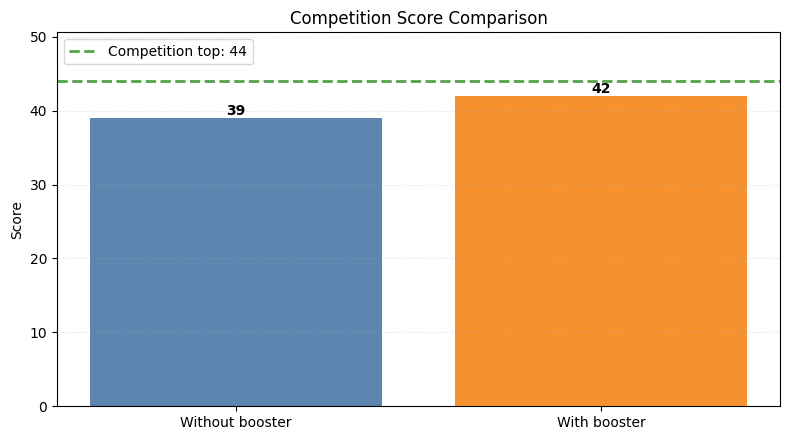

Without booster: 39
With booster: 42
Competition top (max possible on this split): 44


In [12]:
import matplotlib.pyplot as plt

if "train_en_model" not in globals() or "test_idx" not in globals():
    raise ValueError("Run the training cell first.")

score_without_booster = None
if "test_score" in globals():
    score_without_booster = float(test_score)
elif "score" in globals():
    score_without_booster = float(score)
else:
    raise ValueError("No baseline score found. Run the model scoring cells first.")

score_with_booster = float(second_stage_test_score_en) if "second_stage_test_score_en" in globals() else None

if "max_possible_score" in globals():
    competition_top = float(max_possible_score)
else:
    account_truth = (
        train_en_model.iloc[test_idx][["author_id", "is_bot"]]
        .groupby("author_id", as_index=False)["is_bot"]
        .max()
    )
    competition_top = float(4 * int(account_truth["is_bot"].sum()))

labels = ["Without booster"]
scores = [score_without_booster]
colors = ["#4c78a8"]

if score_with_booster is not None:
    labels.append("With booster")
    scores.append(score_with_booster)
    colors.append("#f58518")

fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.bar(labels, scores, color=colors, alpha=0.9)
ax.axhline(competition_top, color="#54a24b", linestyle="--", linewidth=2, label=f"Competition top: {competition_top:.0f}")

for bar, value in zip(bars, scores):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        f"{value:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_title("Competition Score Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0, max(max(scores), competition_top) * 1.15)
ax.grid(axis="y", linestyle=":", alpha=0.4)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

print(f"Without booster: {score_without_booster:.0f}")
if score_with_booster is not None:
    print(f"With booster: {score_with_booster:.0f}")
print(f"Competition top (max possible on this split): {competition_top:.0f}")


## Error analysis (aggregate only)


In [13]:
import numpy as np
import pandas as pd

required = ["train_en_model", "test_idx", "post_prob_test"]
missing = [name for name in required if name not in globals()]
if missing:
    raise ValueError(f"Run the training and booster cells first. Missing: {missing}")

analysis_threshold = float(SELECTED_THRESHOLD if "SELECTED_THRESHOLD" in globals() else PREDICTION_THRESHOLD)

posts_eval = train_en_model.iloc[test_idx].copy().reset_index(drop=True)
posts_eval["true_is_bot"] = posts_eval["is_bot"].astype(np.int64)
posts_eval["pred_prob"] = np.asarray(post_prob_test, dtype=np.float32)
posts_eval["pred_is_bot"] = (posts_eval["pred_prob"] >= analysis_threshold).astype(np.int64)

posts_eval["error_type"] = np.where(
    (posts_eval["true_is_bot"] == 1) & (posts_eval["pred_is_bot"] == 0),
    "FN",
    np.where(
        (posts_eval["true_is_bot"] == 0) & (posts_eval["pred_is_bot"] == 1),
        "FP",
        np.where(posts_eval["true_is_bot"] == 1, "TP", "TN"),
    ),
)

post_error_summary_en = (
    posts_eval["error_type"]
    .value_counts()
    .rename_axis("error_type")
    .reset_index(name="n_posts")
)

print("Post-level error summary (first-stage ensemble):")
print(post_error_summary_en.to_string(index=False))

if topic_feature_cols_en:
    topic_rows = []
    for topic_col in topic_feature_cols_en:
        subset = posts_eval[posts_eval[topic_col] > 0]
        if subset.empty:
            continue

        fp = int(((subset["true_is_bot"] == 0) & (subset["pred_is_bot"] == 1)).sum())
        fn = int(((subset["true_is_bot"] == 1) & (subset["pred_is_bot"] == 0)).sum())
        tp = int(((subset["true_is_bot"] == 1) & (subset["pred_is_bot"] == 1)).sum())
        tn = int(((subset["true_is_bot"] == 0) & (subset["pred_is_bot"] == 0)).sum())
        n = int(len(subset))

        topic_rows.append(
            {
                "topic": topic_col.replace("topic_", ""),
                "n_posts": n,
                "fp_posts": fp,
                "fn_posts": fn,
                "tp_posts": tp,
                "tn_posts": tn,
                "error_rate": (fp + fn) / n if n else 0.0,
                "bot_rate": subset["true_is_bot"].mean(),
            }
        )

    topic_post_error_report_en = pd.DataFrame(topic_rows)
    if not topic_post_error_report_en.empty:
        min_topic_posts = int(EXPERIMENT_CONFIG.get("error_analysis_min_topic_posts", 20))
        topic_post_error_report_en = topic_post_error_report_en.sort_values(
            by=["error_rate", "n_posts"], ascending=[False, False]
        )

        print("\nTopic-level post errors (filtering tiny buckets):")
        print(
            topic_post_error_report_en[topic_post_error_report_en["n_posts"] >= min_topic_posts]
            .head(15)
            .to_string(index=False)
        )
    else:
        print("\nNo topic matches found in the test split.")
else:
    print("\nTopic features are disabled, so no topic-level error table was computed.")

if "second_stage_account_predictions_en" in globals() and isinstance(second_stage_account_predictions_en, pd.DataFrame):
    account_eval = second_stage_account_predictions_en.copy()
    if "true_is_bot" not in account_eval.columns and "is_bot" in account_eval.columns:
        account_eval = account_eval.rename(columns={"is_bot": "true_is_bot"})
else:
    account_eval = (
        posts_eval.groupby("author_id", as_index=False)
        .agg(
            true_is_bot=("true_is_bot", "max"),
            mean_prob=("pred_prob", "mean"),
            any_pred=("pred_is_bot", "max"),
        )
        .copy()
    )

    if ACCOUNT_DECISION_RULE == "any":
        account_eval["pred_is_bot"] = account_eval["any_pred"].astype(np.int64)
        account_eval["pred_prob"] = account_eval["any_pred"].astype(np.float32)
    else:
        account_eval["pred_is_bot"] = (account_eval["mean_prob"] >= analysis_threshold).astype(np.int64)
        account_eval["pred_prob"] = account_eval["mean_prob"].astype(np.float32)

if topic_feature_cols_en:
    topic_strength = posts_eval.groupby("author_id")[topic_feature_cols_en].mean()
    dominant_topic = topic_strength.idxmax(axis=1).str.replace("topic_", "", regex=False)
    dominant_topic = dominant_topic.where(topic_strength.max(axis=1) > 0, "no_topic_match")
else:
    dominant_topic = pd.Series("no_topic_features", index=account_eval["author_id"])

account_eval = account_eval.merge(
    dominant_topic.rename("dominant_topic"),
    left_on="author_id",
    right_index=True,
    how="left",
)

account_eval["error_type"] = np.where(
    (account_eval["true_is_bot"] == 1) & (account_eval["pred_is_bot"] == 0),
    "FN",
    np.where(
        (account_eval["true_is_bot"] == 0) & (account_eval["pred_is_bot"] == 1),
        "FP",
        np.where(account_eval["true_is_bot"] == 1, "TP", "TN"),
    ),
)

account_tp = int((account_eval["error_type"] == "TP").sum())
account_fn = int((account_eval["error_type"] == "FN").sum())
account_fp = int((account_eval["error_type"] == "FP").sum())
account_tn = int((account_eval["error_type"] == "TN").sum())
account_score = (4 * account_tp) - account_fn - (2 * account_fp)
print(f"\nAccount-level summary: score={account_score} TP={account_tp} FN={account_fn} FP={account_fp} TN={account_tn}")
account_topic_report_en = (
    account_eval.groupby("dominant_topic", as_index=False)
    .agg(
        n_accounts=("author_id", "size"),
        bot_rate=("true_is_bot", "mean"),
        fp_accounts=("error_type", lambda s: int((s == "FP").sum())),
        fn_accounts=("error_type", lambda s: int((s == "FN").sum())),
        tp_accounts=("error_type", lambda s: int((s == "TP").sum())),
        tn_accounts=("error_type", lambda s: int((s == "TN").sum())),
    )
)

account_topic_report_en["error_rate"] = (
    account_topic_report_en["fp_accounts"] + account_topic_report_en["fn_accounts"]
) / account_topic_report_en["n_accounts"]
account_topic_report_en = account_topic_report_en.sort_values(
    by=["error_rate", "n_accounts"], ascending=[False, False]
)

min_topic_accounts = int(EXPERIMENT_CONFIG.get("error_analysis_min_topic_accounts", 5))
print("\nAccount-level errors by dominant topic:")
print(
    account_topic_report_en[account_topic_report_en["n_accounts"] >= min_topic_accounts]
    .head(15)
    .to_string(index=False)
)

fp_examples = posts_eval[
    (posts_eval["true_is_bot"] == 0) & (posts_eval["pred_is_bot"] == 1)
][["author_id", "text_clean", "pred_prob"]].sort_values("pred_prob", ascending=False).head(10)
fn_examples = posts_eval[
    (posts_eval["true_is_bot"] == 1) & (posts_eval["pred_is_bot"] == 0)
][["author_id", "text_clean", "pred_prob"]].sort_values("pred_prob", ascending=True).head(10)

hard_case_examples_en = pd.concat(
    [
        fp_examples.assign(error_type="FP"),
        fn_examples.assign(error_type="FN"),
    ],
    ignore_index=True,
)

if not hard_case_examples_en.empty:
    print("\nSample hard cases (for pattern inspection, not rule memorization):")
    print(hard_case_examples_en.to_string(index=False))


Post-level error summary (first-stage ensemble):
error_type  n_posts
        TN     1164
        TP      436
        FP      114
        FN       56

Topic features are disabled, so no topic-level error table was computed.

Account-level summary: score=42 TP=11 FN=0 FP=1 TN=57

Account-level errors by dominant topic:
   dominant_topic  n_accounts  bot_rate  fp_accounts  fn_accounts  tp_accounts  tn_accounts  error_rate
no_topic_features          69   0.15942            1            0           11           57    0.014493

Sample hard cases (for pattern inspection, not rule memorization):
                           author_id                                                                                                                                                                                                                                                                                                   text_clean  pred_prob error_type
87f87356-1719-ab8e-88f6-9dd471800a5a         

## Booster search prep (do not run long sweep yet)


In [14]:
from pathlib import Path
from datetime import datetime
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_root = Path(globals().get("PROJECT_ROOT", Path(".")))
ARTIFACTS_DIR = Path(globals().get("ARTIFACTS_DIR", base_root / "artifacts")).resolve()
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

globals()["ARTIFACTS_DIR"] = ARTIFACTS_DIR

SEARCH_RESULTS_PATH = ARTIFACTS_DIR / "booster_search_results.csv"
SEARCH_BEST_PATH = ARTIFACTS_DIR / "booster_best_config.json"

SWEEP_NOTEBOOK_PATH = Path(
    globals().get("SWEEP_NOTEBOOK_PATH", base_root / "script_fr.ipynb")
).resolve()
globals()["SWEEP_NOTEBOOK_PATH"] = SWEEP_NOTEBOOK_PATH

BOOSTER_SEARCH_SPACE = {
    "second_stage_profile": ["auto", "legacy", "regularized"],
    "second_stage_max_iter": [200, 300, 450],
    "second_stage_max_depth": [3, 4, 5],
    "second_stage_l2": [0.1, 0.2, 0.5, 1.0],
    "second_stage_min_data_in_leaf": [10, 20, 40],
    "second_stage_subsample": [0.7, 0.8, 1.0],
    "second_stage_rsm": [0.7, 0.8, 1.0],
    "second_stage_blend_alphas": [[1.0], [1.0, 0.9], [1.0, 0.9, 0.8, 0.7]],
    "second_stage_min_gain_vs_ensemble": [0, 1, 2],
    "use_second_stage_account_model": [True],
    "second_stage_use_blend": [True, False],
    "second_stage_max_extra_fp_vs_ensemble": [0, 1, 2],
    "account_min_bot_posts": [1, 2, 3],
    "account_min_bot_post_rate": [0.0, 0.10, 0.20],
    "second_stage_post_calibrate": [True],
    "second_stage_account_min_bot_posts_grid": [[1, 2], [1, 2, 3]],
    "second_stage_account_min_bot_post_rate_grid": [[0.0, 0.10], [0.0, 0.10, 0.20]],
    "second_stage_min_val_accounts_for_booster": [10, 20, 30],
    "second_stage_oof_use_external_pretrain": [False, True],
    "second_stage_use_oof_features": [True],
    "second_stage_oof_folds": [3, 4],
    "second_stage_oof_epochs": [3, 4],
    "second_stage_oof_seeds": [[13], [13, 42]],
}

print("Search space prepared for later long run.")
print(f"- dimensions: {len(BOOSTER_SEARCH_SPACE)}")
print(f"- artifacts dir: {ARTIFACTS_DIR}")
print(f"- results file: {SEARCH_RESULTS_PATH}")
print(f"- notebook path for sweep source: {SWEEP_NOTEBOOK_PATH}")
if not SWEEP_NOTEBOOK_PATH.exists():
    print(
        "Warning: notebook source file not found now. "
        "Before running sweep, set SWEEP_SETTINGS['notebook_path'] to your .ipynb path if needed."
    )


def _safe_float(value):
    try:
        return float(value)
    except Exception:
        return np.nan


def log_current_booster_run(run_name=None, notes="", verbose=True):
    SEARCH_RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
    SEARCH_BEST_PATH.parent.mkdir(parents=True, exist_ok=True)

    timestamp = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")
    if run_name is None:
        run_name = f"run_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"

    row = {
        "timestamp_utc": timestamp,
        "run_name": run_name,
        "notes": notes,
        "ensemble_score": _safe_float(globals().get("test_score_ensemble_en", np.nan)),
        "booster_score": _safe_float(globals().get("second_stage_test_score_en", np.nan)),
        "score_gain": _safe_float(globals().get("second_stage_test_score_en", np.nan)) - _safe_float(globals().get("test_score_ensemble_en", np.nan)),
        "seed_mean_score": _safe_float(globals().get("seed_mean_score_en", np.nan)),
        "seed_std_score": _safe_float(globals().get("seed_std_score_en", np.nan)),
        "selected_profile": globals().get("second_stage_selected_profile_en", ""),
        "selected_alpha": _safe_float(globals().get("second_stage_alpha_en", np.nan)),
        "selected_threshold": _safe_float(globals().get("second_stage_selected_threshold_en", np.nan)),
        "feature_source": globals().get("second_stage_fit_feature_source_en", ""),
        "config_json": json.dumps(EXPERIMENT_CONFIG, sort_keys=True),
    }

    current = pd.DataFrame([row])
    if SEARCH_RESULTS_PATH.exists():
        history = pd.read_csv(SEARCH_RESULTS_PATH)
        history = pd.concat([history, current], ignore_index=True)
    else:
        history = current

    history = history.drop_duplicates(subset=["run_name"], keep="last")
    history.to_csv(SEARCH_RESULTS_PATH, index=False)

    leaderboard = history.sort_values(
        by=["booster_score", "score_gain", "seed_std_score"],
        ascending=[False, False, True],
    )

    if len(leaderboard):
        best_row = leaderboard.iloc[0].to_dict()
        best_payload = {
            "saved_at_utc": timestamp,
            "best_run": best_row,
            "best_config": json.loads(best_row.get("config_json", "{}")),
        }
        SEARCH_BEST_PATH.write_text(json.dumps(best_payload, indent=2))

    if verbose:
        print(f"Saved run to {SEARCH_RESULTS_PATH}")
        print(f"Best config snapshot saved to {SEARCH_BEST_PATH}")
        print("\nTop runs:")
        print(
            leaderboard[
                [
                    "run_name",
                    "ensemble_score",
                    "booster_score",
                    "score_gain",
                    "seed_std_score",
                    "selected_profile",
                    "feature_source",
                ]
            ].head(10).to_string(index=False)
        )

    return history


def plot_search_history(top_n=20):
    if not SEARCH_RESULTS_PATH.exists():
        raise FileNotFoundError(f"No results found at {SEARCH_RESULTS_PATH}")

    history = pd.read_csv(SEARCH_RESULTS_PATH)
    if history.empty:
        raise ValueError("Search history is empty.")

    leaderboard = history.sort_values(
        by=["booster_score", "score_gain", "seed_std_score"],
        ascending=[False, False, True],
    ).head(top_n)

    plt.figure(figsize=(10, 5))
    x = np.arange(len(leaderboard))
    plt.plot(x, leaderboard["ensemble_score"].to_numpy(), marker="o", label="without booster")
    plt.plot(x, leaderboard["booster_score"].to_numpy(), marker="o", label="with booster")
    plt.xticks(x, leaderboard["run_name"], rotation=70)
    plt.ylabel("Competition score")
    plt.title(f"Top {top_n} logged runs")
    plt.grid(axis="y", linestyle=":", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()



Search space prepared for later long run.
- dimensions: 23
- artifacts dir: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/artifacts
- results file: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/artifacts/booster_search_results.csv
- notebook path for sweep source: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/script_fr.ipynb


## Automated booster sweep runner


In [15]:

from pathlib import Path
import copy
import json
import math
import random
import time
import traceback

import numpy as np
import pandas as pd

if "BOOSTER_SEARCH_SPACE" not in globals() or "log_current_booster_run" not in globals():
    raise ValueError("Run the Booster search prep cell first.")
if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")
if "train_en_model" not in globals() or "fit_idx" not in globals() or "test_idx" not in globals():
    raise ValueError("Run the Train-Test split and booster baseline cells first.")

ARTIFACTS_DIR = Path(
    globals().get("ARTIFACTS_DIR", Path(globals().get("PROJECT_ROOT", Path("."))) / "artifacts")
).resolve()
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
SWEEP_TRIALS_PATH = ARTIFACTS_DIR / "booster_sweep_trials.csv"

DEFAULT_NOTEBOOK_PATH = Path(
    globals().get("SWEEP_NOTEBOOK_PATH", Path(globals().get("PROJECT_ROOT", Path("."))) / "script_fr.ipynb")
).resolve()

SWEEP_SETTINGS = {
    "n_trials": 80,
    "run_prefix": "sweep",
    "random_seed": 42,
    "include_current_config": True,
    "sample_without_replacement": True,
    "stop_on_error": False,
    "apply_best_config_at_end": False,
    "plot_top_n": 20,
    "notebook_path": str(DEFAULT_NOTEBOOK_PATH),
}

print("Sweep runner ready. Edit SWEEP_SETTINGS, then call `run_booster_sweep()`.")
print(f"- trials file: {SWEEP_TRIALS_PATH}")
print(f"- notebook path: {SWEEP_SETTINGS['notebook_path']}")


def _space_size(space):
    return int(math.prod(len(values) for values in space.values()))


def _config_signature(cfg):
    return json.dumps(cfg, sort_keys=True)


def _draw_random_override(space, rng):
    out = {}
    for key, values in space.items():
        out[key] = copy.deepcopy(values[rng.randrange(len(values))])
    return out


def _extract_space_override(config, space):
    out = {}
    for key in space.keys():
        if key in config:
            out[key] = copy.deepcopy(config[key])
    return out


def _candidate_notebook_paths(nb_path=None):
    candidates = []

    if nb_path:
        candidates.append(Path(nb_path))

    sweep_global = globals().get("SWEEP_NOTEBOOK_PATH")
    if sweep_global:
        candidates.append(Path(sweep_global))

    project_root = Path(globals().get("PROJECT_ROOT", Path(".")))
    candidates.append(project_root / "script_fr.ipynb")
    candidates.append(Path("script_fr.ipynb"))

    out = []
    seen = set()
    for p in candidates:
        try:
            rp = p.expanduser().resolve()
        except Exception:
            continue
        key = str(rp)
        if key in seen:
            continue
        seen.add(key)
        out.append(rp)
    return out


def _load_booster_cell_source_from_notebook(nb_path=None):
    checked = []

    for candidate in _candidate_notebook_paths(nb_path=nb_path):
        checked.append(str(candidate))
        if not candidate.exists():
            continue

        try:
            nb = json.loads(candidate.read_text())
        except Exception:
            continue

        cells = nb.get("cells", [])
        for idx, cell in enumerate(cells):
            if cell.get("cell_type") != "markdown":
                continue
            md = "".join(cell.get("source", []))
            if "## Strongest booster (account-level second stage)" in md:
                if idx + 1 >= len(cells):
                    break
                code_cell = cells[idx + 1]
                if code_cell.get("cell_type") != "code":
                    break
                print(f"Loaded booster source from: {candidate}")
                return "".join(code_cell.get("source", []))

    raise FileNotFoundError(
        "Could not locate notebook file containing the booster cell. "
        "Set SWEEP_SETTINGS['notebook_path'] to your .ipynb path. "
        f"Checked: {checked}"
    )


def _build_trial_queue(base_config, space, n_trials, include_current, sample_without_replacement, rng):
    queue = []
    seen = set()

    if include_current:
        current_override = _extract_space_override(base_config, space)
        sig = _config_signature(current_override)
        seen.add(sig)
        queue.append(current_override)

    max_unique = _space_size(space)
    target = int(n_trials)
    if include_current and target > 0:
        target -= 1

    if sample_without_replacement:
        target = min(target, max_unique - len(seen))

    attempts = 0
    max_attempts = max(1000, target * 80)

    while len(queue) < (target + (1 if include_current else 0)):
        cand = _draw_random_override(space, rng)
        sig = _config_signature(cand)

        if sample_without_replacement and sig in seen:
            attempts += 1
            if attempts > max_attempts:
                break
            continue

        seen.add(sig)
        queue.append(cand)

    return queue


def _run_one_trial(base_config, override_cfg, run_name, booster_code, stop_on_error=False):
    trial_config = copy.deepcopy(base_config)
    trial_config.update(copy.deepcopy(override_cfg))
    globals()["EXPERIMENT_CONFIG"] = trial_config

    start = time.time()
    try:
        exec(booster_code, globals())
        duration = time.time() - start

        notes_payload = {
            "duration_sec": round(float(duration), 2),
            "override": override_cfg,
        }
        log_current_booster_run(
            run_name=run_name,
            notes=json.dumps(notes_payload, sort_keys=True),
            verbose=False,
        )

        return {
            "run_name": run_name,
            "status": "ok",
            "duration_sec": float(duration),
            "ensemble_score": float(globals().get("test_score_ensemble_en", np.nan)),
            "booster_score": float(globals().get("second_stage_test_score_en", np.nan)),
            "score_gain": float(globals().get("second_stage_test_score_en", np.nan))
            - float(globals().get("test_score_ensemble_en", np.nan)),
            "seed_std_score": float(globals().get("seed_std_score_en", np.nan)),
            "selected_profile": str(globals().get("second_stage_selected_profile_en", "")),
            "selected_alpha": float(globals().get("second_stage_alpha_en", np.nan)),
            "selected_threshold": float(globals().get("second_stage_selected_threshold_en", np.nan)),
            "feature_source": str(globals().get("second_stage_fit_feature_source_en", "")),
            "error": "",
            "override_json": json.dumps(override_cfg, sort_keys=True),
        }
    except Exception as exc:
        duration = time.time() - start
        err = f"{type(exc).__name__}: {exc}"
        tb = traceback.format_exc(limit=4)

        row = {
            "run_name": run_name,
            "status": "failed",
            "duration_sec": float(duration),
            "ensemble_score": np.nan,
            "booster_score": np.nan,
            "score_gain": np.nan,
            "seed_std_score": np.nan,
            "selected_profile": "",
            "selected_alpha": np.nan,
            "selected_threshold": np.nan,
            "feature_source": "",
            "error": f"{err} | {tb}",
            "override_json": json.dumps(override_cfg, sort_keys=True),
        }

        if stop_on_error:
            raise
        return row


def run_booster_sweep(settings=None):
    cfg = copy.deepcopy(SWEEP_SETTINGS)
    if settings is not None:
        cfg.update(settings)

    n_trials = int(cfg.get("n_trials", 50))
    if n_trials < 1:
        raise ValueError("n_trials must be >= 1")

    rng = random.Random(int(cfg.get("random_seed", 42)))
    run_prefix = str(cfg.get("run_prefix", "sweep"))
    include_current = bool(cfg.get("include_current_config", True))
    sample_wo_repl = bool(cfg.get("sample_without_replacement", True))
    stop_on_error = bool(cfg.get("stop_on_error", False))
    apply_best = bool(cfg.get("apply_best_config_at_end", False))
    plot_top_n = int(cfg.get("plot_top_n", 20))
    notebook_path = cfg.get("notebook_path", str(DEFAULT_NOTEBOOK_PATH))

    base_config = copy.deepcopy(EXPERIMENT_CONFIG)
    booster_code = _load_booster_cell_source_from_notebook(nb_path=notebook_path)

    queue = _build_trial_queue(
        base_config=base_config,
        space=BOOSTER_SEARCH_SPACE,
        n_trials=n_trials,
        include_current=include_current,
        sample_without_replacement=sample_wo_repl,
        rng=rng,
    )

    if not queue:
        raise ValueError("No trials were generated. Check search space and settings.")

    print(
        f"Starting sweep: trials={len(queue)}, include_current={include_current}, "
        f"without_replacement={sample_wo_repl}, space_size={_space_size(BOOSTER_SEARCH_SPACE):,}"
    )

    rows = []
    sweep_start = time.time()
    for idx, override_cfg in enumerate(queue, start=1):
        run_name = f"{run_prefix}_{idx:04d}"
        print(f"\n[{idx}/{len(queue)}] Running {run_name} ...")

        row = _run_one_trial(
            base_config=base_config,
            override_cfg=override_cfg,
            run_name=run_name,
            booster_code=booster_code,
            stop_on_error=stop_on_error,
        )
        rows.append(row)

        if row["status"] == "ok":
            print(
                f"{run_name}: booster={row['booster_score']:.1f}, ensemble={row['ensemble_score']:.1f}, "
                f"gain={row['score_gain']:.1f}, dur={row['duration_sec']:.1f}s"
            )
        else:
            print(f"{run_name}: FAILED -> {row['error'].split('|')[0]}")

    total_dur = time.time() - sweep_start
    sweep_df = pd.DataFrame(rows)

    SWEEP_TRIALS_PATH.parent.mkdir(parents=True, exist_ok=True)
    if SWEEP_TRIALS_PATH.exists():
        old = pd.read_csv(SWEEP_TRIALS_PATH)
        sweep_df = pd.concat([old, sweep_df], ignore_index=True)

    sweep_df = sweep_df.drop_duplicates(subset=["run_name"], keep="last")
    sweep_df.to_csv(SWEEP_TRIALS_PATH, index=False)

    globals()["booster_sweep_last_results_en"] = sweep_df.copy()

    # Restore baseline config to avoid accidental side-effects after sweep.
    globals()["EXPERIMENT_CONFIG"] = base_config

    ok_df = sweep_df[sweep_df["status"] == "ok"].copy()
    if not ok_df.empty:
        ok_df = ok_df.sort_values(
            by=["booster_score", "score_gain", "seed_std_score"],
            ascending=[False, False, True],
        )

    print("\nSweep finished.")
    print(f"- total duration: {total_dur/60.0:.1f} min")
    print(f"- successful trials: {int((sweep_df['status'] == 'ok').sum())}")
    print(f"- failed trials: {int((sweep_df['status'] == 'failed').sum())}")
    print(f"- trials csv: {SWEEP_TRIALS_PATH}")

    if not ok_df.empty:
        print("\nTop sweep trials:")
        print(
            ok_df[
                [
                    "run_name",
                    "ensemble_score",
                    "booster_score",
                    "score_gain",
                    "seed_std_score",
                    "selected_profile",
                    "feature_source",
                    "duration_sec",
                ]
            ].head(10).to_string(index=False)
        )

    if apply_best and SEARCH_BEST_PATH.exists():
        best_payload = json.loads(SEARCH_BEST_PATH.read_text())
        best_config = best_payload.get("best_config", {})
        if best_config:
            globals()["EXPERIMENT_CONFIG"] = best_config
            print("\nApplied best config from SEARCH_BEST_PATH into EXPERIMENT_CONFIG.")

    if plot_top_n > 0:
        try:
            plot_search_history(top_n=plot_top_n)
        except Exception as exc:
            print(f"Could not render history plot: {exc}")

    return sweep_df


# Example usage (manual):
'''sweep_results = run_booster_sweep({
    "n_trials": 20,
    "run_prefix": "week_sweep",
    "include_current_config": True,
    "sample_without_replacement": True,
    "plot_top_n": 25,
    # Optional in Colab: set this if auto-detection does not find your notebook file.
    "notebook_path": "/content/drive/MyDrive/bot_or_not_McHacks_2026/script_fr.ipynb",
 })'''

Sweep runner ready. Edit SWEEP_SETTINGS, then call `run_booster_sweep()`.
- trials file: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/artifacts/booster_sweep_trials.csv
- notebook path: /Users/adrienbelanger/Library/GitHub/bot_or_not_McHacks_2026/script_fr.ipynb


'sweep_results = run_booster_sweep({\n    "n_trials": 20,\n    "run_prefix": "week_sweep",\n    "include_current_config": True,\n    "sample_without_replacement": True,\n    "plot_top_n": 25,\n    # Optional in Colab: set this if auto-detection does not find your notebook file.\n    "notebook_path": "/content/drive/MyDrive/bot_or_not_McHacks_2026/script_fr.ipynb",\n })'